In [1]:
from tqdm import tqdm
from os import listdir
from random import *
seed(0)


import pandas as pd

from pylab import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cuda:0"

## Data trepanation

In [2]:
dataset = 'laptev'
folder_train, folder_val, folder_test = dataset + '/train/maps/', dataset + '/valid/maps/', dataset + '/test/maps/'
train_files, val_files, test_files = sorted([file for file in listdir(folder_train)])[1346:],\
                                     sorted([file for file in listdir(folder_val)]),\
                                     sorted([file for file in listdir(folder_test)]) # + 1200

sample = torch.load(folder_train + train_files[1])
grid = torch.load(dataset + "/train/grid.pt")
coverage = pd.read_csv(dataset + "/train/coverage.csv")

len(train_files), len(val_files), len(test_files)

(1812, 366, 365)

In [3]:
keys = sample.keys()

In [4]:
def nan_check(tensor: torch.Tensor) -> bool:
    return True in tensor.isnan()

for key in keys:
    print(nan_check(sample[key]), key, sample[key].shape)

True cryosat.sic torch.Size([360, 500])
True cryosat.sit torch.Size([360, 500])
True jaxa.sic_asc torch.Size([360, 500])
True jaxa.sic_desc torch.Size([360, 500])
True jaxa.sic torch.Size([360, 500])
False gfs.f0d.temperature torch.Size([360, 500])
False gfs.f0d.pressure torch.Size([360, 500])
False gfs.f0d.wind_u torch.Size([360, 500])
False gfs.f0d.wind_v torch.Size([360, 500])
False gfs.f0d.wind torch.Size([360, 500])
False gfs.f1d.temperature torch.Size([360, 500])
False gfs.f1d.pressure torch.Size([360, 500])
False gfs.f1d.wind_u torch.Size([360, 500])
False gfs.f1d.wind_v torch.Size([360, 500])
False gfs.f1d.wind torch.Size([360, 500])
False gfs.f2d.temperature torch.Size([360, 500])
False gfs.f2d.pressure torch.Size([360, 500])
False gfs.f2d.wind_u torch.Size([360, 500])
False gfs.f2d.wind_v torch.Size([360, 500])
False gfs.f2d.wind torch.Size([360, 500])
False gfs.f3d.temperature torch.Size([360, 500])
False gfs.f3d.pressure torch.Size([360, 500])
False gfs.f3d.wind_u torch.Siz

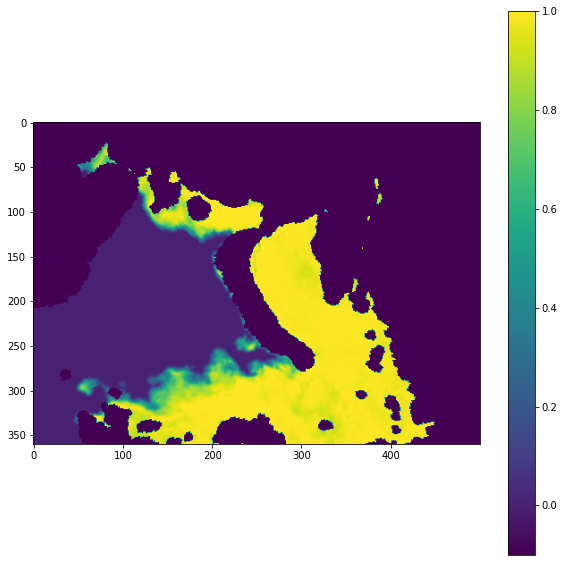

In [62]:
def preprocess_image(tensor: torch.Tensor) -> torch.Tensor:
    return (torch.nan_to_num(tensor, nan=-10.0))/100 # + grid['land']*10

plt.figure(figsize=(10,10))
axs = imshow(preprocess_image(sample["jaxa.sic"]).reshape(360, 500).detach().cpu().numpy())
plt.colorbar()

In [63]:
images_train = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(train_files)))]
images_val = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(val_files)))]
images_test = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:03<00:00, 114.40it/s]


In [64]:
images_tensor_train, images_tensor_val, images_tensor_test = torch.stack(images_train).to(device),\
                                                             torch.stack(images_val).to(device),\
                                                             torch.stack(images_test).to(device)
images_tensor_train.shape

torch.Size([1812, 360, 500])

## Model trepanation

#### Check whether NaNs of the SIC part in the same positions or not

In [8]:
images_train_raw = [torch.load(folder_train + train_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(train_files)))]

images_val_raw = [torch.load(folder_val + val_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(val_files)))]

def handler(data: dict):
    try:
#        print(data["jaxa.sic"])
        return data["jaxa.sic"]
    except:
#        print(data["jaxa.sic_asc"])
        return data["jaxa.sic_asc"]
    
images_test_raw = [handler(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:06<00:00, 52.48it/s]


In [9]:
ref_mask = torch.isnan(images_train_raw[0])

diffs = []

for split in [images_train_raw, images_val_raw, images_test_raw]:
    data_2_check = [torch.logical_xor(torch.isnan(image), ref_mask) for image in split]
    diffs.append(data_2_check)

In [10]:
# ultimate mask correcions for Laptev

diffs[2][181] = ~diffs[2][181]

diffs[0][1045] = diffs[0][1044]

In [11]:
from copy import deepcopy

ref_mask = torch.isnan(images_train_raw[0])
ultimate_mask = deepcopy(ref_mask)

for split in diffs:
    print('---')
    for i, image in enumerate(split[:]):
        if (torch.sum(image.float()) > 2*981.):
            print(i, torch.sum(image.float()))
        ultimate_mask = torch.logical_or(ultimate_mask, image)

---
457 tensor(2107.)
---
76 tensor(2075.)
---
60 tensor(2162.)
181 tensor(101124.)


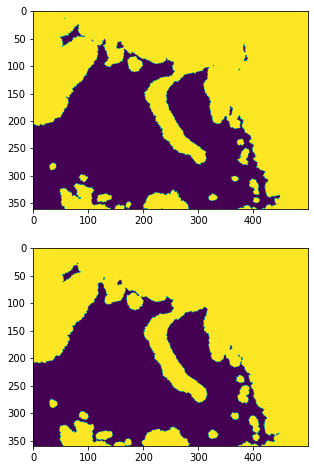

In [74]:
ref_mask = torch.isnan(images_train_raw[0])

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].imshow(ref_mask)
ax[1].imshow(ultimate_mask)
# plt.colorbar()

In [12]:
torch.save(ultimate_mask, 'mask_barents.pt')

In [13]:
ultimate_mask = torch.load('mask_barents.pt')

#### Actual experiments

In [14]:
epochs = 1000
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 5

In [84]:
images_in , images_out = load_data(batch_size, images_tensor_val, d_in, d_out)

images_in[:,-1][:, None, :, :].shape

torch.Size([8, 1, 360, 500])

In [85]:
test_output = model(images_in)
test_output.shape

torch.Size([8, 3, 360, 500])

In [97]:
sum_output_c = test_output + images_in[:,-1][:, None, :, :]
sum_output_n = test_output + images_in[:,-1, None, :, :].repeat(1, 3, 1, 1)
test_output.shape

torch.Size([8, 3, 360, 500])

In [98]:
torch.all(sum_output_c == sum_output_n)

tensor(True, device='cuda:0')

In [87]:
images_in.shape

torch.Size([8, 7, 360, 500])

In [ ]:
images_in

In [79]:
torch.all(images_in[:,-1] == images_in[:,-1][:, None, :, :].squeeze())

tensor(True, device='cuda:0')

In [83]:
images_in[0][0]

NameError: name 'images_in' is not defined

In [60]:
ultimate_mask[None, None, :].shape

torch.Size([1, 1, 360, 500])

In [98]:
ultimate_mask.to('cuda:0').shape

torch.Size([360, 500])

In [99]:
images_in[0][0].shape

torch.Size([360, 500])

TypeError: Invalid shape (75230,) for image data

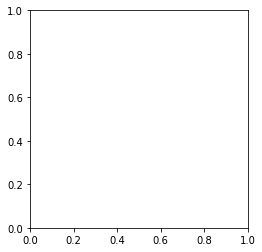

In [101]:
imshow(images_in[0][0].detach().cpu()[~ultimate_mask.cpu()])

In [147]:
def average(data: list) -> float:
    return sum(data)/len(data)

def load_data(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)

def train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion_mse = nn.MSELoss()
#weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    for epoch in range(epochs):
        model.train()
        
        images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
        optimizer.zero_grad()
        model_out = model(images_in) + images_in[:,-1, None, :, :].repeat(1, 3, 1, 1)
        
        adapted_mask = ~ultimate_mask[None, None, :].repeat(batch_size,3,1,1)
        
        loss = criterion(model_out[adapted_mask], images_out[adapted_mask])
        loss.backward() # retain_graph=True
        
#        print(model_out.shape, images_out.shape)
        
        optimizer.step()
        
        if epoch % eval_step == 0:
            with torch.no_grad():
                model.eval()

                mae_total, rmse_total, mape_total = [], [], []

                total_test_len = len(images_tensor_test)
                start_point, steps = 0, int(total_test_len/(d_in + d_out))

                for i in range(steps):
                    images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                            images_tensor_test[start_point+d_in:start_point+d_in+d_out]

                    start_point += d_in + d_out

                   # model_out = images_in[-1][None, :, :].repeat(3, 1, 1)[None, :, : , :]
                    model_out = model(images_in[None, :, :, :]) + images_in[-1].repeat(3, 1, 1)[None, :, :, :] 

                    #                print(model_out.shape)
                
                    adapted_mask = ~ultimate_mask[None, None, :].repeat(1,3,1,1)

                    loss_mse = criterion_mse(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])
                    loss_mae = criterion(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])

                    mae_total.append(loss_mae.detach().cpu().numpy())
                    rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                
            
                wandb.log(
                    {
                     "test/test_MAE": average(mae_total), 
                     "test/test_RMSE": average(rmse_total)
                    }
                )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [123]:
torch.tensor([[1, 0], [0, 1]])[None, None, :].repeat(8,3, 1, 1)[0]

Error in callback <function _WandbInit._resume_backend at 0x7f9f721b2440> (for pre_run_cell):


Exception: The wandb backend process has shutdown

tensor([[[1, 0],
         [0, 1]],

        [[1, 0],
         [0, 1]],

        [[1, 0],
         [0, 1]]])

Error in callback <function _WandbInit._pause_backend at 0x7f9f721b2680> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [151]:
architecture = "UNet_7:3_per"
i = 0
wandb.init(project="initial_tests_RE", entity="sea-ice-prediction", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

wandb: wandb version 0.15.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [140]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [148]:
from models.unet.unet.unet_model import UNet

epochs = 300
d_in, d_out = 7, 3
batch_size = 8
lr = 1e-3
eval_step = 1
criterion = nn.L1Loss()
model = UNet(d_in, d_out).to(device)

train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

Epoch  0 , test MAE -  0.09681898355484009
Epoch  1 , test MAE -  0.09135219785902235
Epoch  2 , test MAE -  0.08512350585725573
Epoch  3 , test MAE -  0.07950745688544379
Epoch  4 , test MAE -  0.09982799159155951
Epoch  5 , test MAE -  0.12156671947903103
Epoch  6 , test MAE -  0.08323589298460218
Epoch  7 , test MAE -  0.1638021469116211
Epoch  8 , test MAE -  0.6809524959988065
Epoch  9 , test MAE -  0.9950923919677734
Epoch  10 , test MAE -  0.2749720944298638
Epoch  11 , test MAE -  0.3509878052605523
Epoch  12 , test MAE -  0.27863650851779515
Epoch  13 , test MAE -  0.27229110399882
Epoch  14 , test MAE -  0.24195684327019584
Epoch  15 , test MAE -  0.2139559586842855
Epoch  16 , test MAE -  0.19131796889834934
Epoch  17 , test MAE -  0.16692573494381374
Epoch  18 , test MAE -  0.14096181922488743
Epoch  19 , test MAE -  0.10475716988245647
Epoch  20 , test MAE -  0.12932864824930826
Epoch  21 , test MAE -  0.05077700482474433
Epoch  22 , test MAE -  0.09355532460742527
Epoch  

Epoch  184 , test MAE -  0.028280569447411433
Epoch  185 , test MAE -  0.029266917043262057
Epoch  186 , test MAE -  0.029483685890833538
Epoch  187 , test MAE -  0.029030425681008235
Epoch  188 , test MAE -  0.02869965632756551
Epoch  189 , test MAE -  0.028357373343573675
Epoch  190 , test MAE -  0.028015739387936063
Epoch  191 , test MAE -  0.027717386682828266
Epoch  192 , test MAE -  0.027661520573827956
Epoch  193 , test MAE -  0.02878699368900723
Epoch  194 , test MAE -  0.02919019924269782
Epoch  195 , test MAE -  0.029284175899293687
Epoch  196 , test MAE -  0.02956312232547336
Epoch  197 , test MAE -  0.02937194373872545
Epoch  198 , test MAE -  0.028577546278635662
Epoch  199 , test MAE -  0.027880489826202393
Epoch  200 , test MAE -  0.02755687137444814
Epoch  201 , test MAE -  0.027961552143096924
Epoch  202 , test MAE -  0.028423405355877347
Epoch  203 , test MAE -  0.028802620040045843
Epoch  204 , test MAE -  0.028664708137512207
Epoch  205 , test MAE -  0.0279581778579

KeyboardInterrupt: 

In [152]:
epochs = 3200
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-4, eval_step)

Epoch  0 , test MAE -  0.02794077330165439
Epoch  1 , test MAE -  0.02772218154536353
Epoch  2 , test MAE -  0.02777940034866333
Epoch  3 , test MAE -  0.027926123804516263
Epoch  4 , test MAE -  0.027952588266796537
Epoch  5 , test MAE -  0.027892013390858967
Epoch  6 , test MAE -  0.02786181370417277
Epoch  7 , test MAE -  0.02781782216495938
Epoch  8 , test MAE -  0.027720049023628235
Epoch  9 , test MAE -  0.027662126554383173
Epoch  10 , test MAE -  0.02765079339345296
Epoch  11 , test MAE -  0.02761537830034892
Epoch  12 , test MAE -  0.02763509253660838
Epoch  13 , test MAE -  0.02769463426536984
Epoch  14 , test MAE -  0.027762057052718267
Epoch  15 , test MAE -  0.027798586421542697
Epoch  16 , test MAE -  0.027806623114479914
Epoch  17 , test MAE -  0.02775341272354126
Epoch  18 , test MAE -  0.02763488557603624
Epoch  19 , test MAE -  0.02746964328818851
Epoch  20 , test MAE -  0.027297458714909024
Epoch  21 , test MAE -  0.02716618279616038
Epoch  22 , test MAE -  0.0271627

Epoch  182 , test MAE -  0.02693066332075331
Epoch  183 , test MAE -  0.02683613697687785
Epoch  184 , test MAE -  0.0268441637357076
Epoch  185 , test MAE -  0.026894412106937833
Epoch  186 , test MAE -  0.02692477570639716
Epoch  187 , test MAE -  0.026938969890276592
Epoch  188 , test MAE -  0.026881658368640475
Epoch  189 , test MAE -  0.026863454116715327
Epoch  190 , test MAE -  0.026834516061676875
Epoch  191 , test MAE -  0.026951309707429674
Epoch  192 , test MAE -  0.027007309926880732
Epoch  193 , test MAE -  0.02707069284386105
Epoch  194 , test MAE -  0.027073813809288874
Epoch  195 , test MAE -  0.02698583073086209
Epoch  196 , test MAE -  0.026981221304999456
Epoch  197 , test MAE -  0.0270551774236891
Epoch  198 , test MAE -  0.02710912624994914
Epoch  199 , test MAE -  0.027131509449746873
Epoch  200 , test MAE -  0.02712728248702155
Epoch  201 , test MAE -  0.02706028189924028
Epoch  202 , test MAE -  0.026992908782429166
Epoch  203 , test MAE -  0.02701195412211948
E

Epoch  362 , test MAE -  0.026743920312987432
Epoch  363 , test MAE -  0.02672435177697076
Epoch  364 , test MAE -  0.026702634162373014
Epoch  365 , test MAE -  0.026731053988138836
Epoch  366 , test MAE -  0.026875754197438557
Epoch  367 , test MAE -  0.026844705144564312
Epoch  368 , test MAE -  0.026811838150024414
Epoch  369 , test MAE -  0.026685913403828938
Epoch  370 , test MAE -  0.026600932081540424
Epoch  371 , test MAE -  0.026622485783365037
Epoch  372 , test MAE -  0.02678176098399692
Epoch  373 , test MAE -  0.026918248997794256
Epoch  374 , test MAE -  0.026929779185189143
Epoch  375 , test MAE -  0.026872206065389845
Epoch  376 , test MAE -  0.026754236883587308
Epoch  377 , test MAE -  0.026609137654304504
Epoch  378 , test MAE -  0.0265799214442571
Epoch  379 , test MAE -  0.026695950163735285
Epoch  380 , test MAE -  0.02682242790857951
Epoch  381 , test MAE -  0.02681791947947608
Epoch  382 , test MAE -  0.026785029305352107
Epoch  383 , test MAE -  0.0266953110694

Epoch  542 , test MAE -  0.026676358448134527
Epoch  543 , test MAE -  0.02670449846320682
Epoch  544 , test MAE -  0.02669438554180993
Epoch  545 , test MAE -  0.02667688164446089
Epoch  546 , test MAE -  0.026657710472742718
Epoch  547 , test MAE -  0.026616452468766108
Epoch  548 , test MAE -  0.02659192184607188
Epoch  549 , test MAE -  0.026585007707277935
Epoch  550 , test MAE -  0.026581583751572505
Epoch  551 , test MAE -  0.02656384805838267
Epoch  552 , test MAE -  0.026538102163208857
Epoch  553 , test MAE -  0.026518084936671786
Epoch  554 , test MAE -  0.026458342870076496
Epoch  555 , test MAE -  0.02639624642001258
Epoch  556 , test MAE -  0.026370210780037776
Epoch  557 , test MAE -  0.026458892557356093
Epoch  558 , test MAE -  0.026585206389427185
Epoch  559 , test MAE -  0.02666820420159234
Epoch  560 , test MAE -  0.026740267872810364
Epoch  561 , test MAE -  0.026730246014065213
Epoch  562 , test MAE -  0.026869134770499334
Epoch  563 , test MAE -  0.02679828306039

Epoch  722 , test MAE -  0.026577356788847182
Epoch  723 , test MAE -  0.026553625861803692
Epoch  724 , test MAE -  0.026524580187267728
Epoch  725 , test MAE -  0.026467551787694294
Epoch  726 , test MAE -  0.026301148864958022
Epoch  727 , test MAE -  0.026156314545207553
Epoch  728 , test MAE -  0.026090709699524775
Epoch  729 , test MAE -  0.026096219817797344
Epoch  730 , test MAE -  0.026077946027119953
Epoch  731 , test MAE -  0.026092759437031217
Epoch  732 , test MAE -  0.02606286770767636
Epoch  733 , test MAE -  0.026050859027438693
Epoch  734 , test MAE -  0.026095084018177457
Epoch  735 , test MAE -  0.02616642912228902
Epoch  736 , test MAE -  0.026256594392988417
Epoch  737 , test MAE -  0.02633417480521732
Epoch  738 , test MAE -  0.026334176460901897
Epoch  739 , test MAE -  0.02622429860962762
Epoch  740 , test MAE -  0.026116513543658786
Epoch  741 , test MAE -  0.02605191535419888
Epoch  742 , test MAE -  0.026031855079862807
Epoch  743 , test MAE -  0.026214930746

Epoch  902 , test MAE -  0.025839762555228338
Epoch  903 , test MAE -  0.025900286104944017
Epoch  904 , test MAE -  0.02596527338027954
Epoch  905 , test MAE -  0.025900822546746995
Epoch  906 , test MAE -  0.025795070661438838
Epoch  907 , test MAE -  0.02570626801914639
Epoch  908 , test MAE -  0.02573001715872023
Epoch  909 , test MAE -  0.02580450475215912
Epoch  910 , test MAE -  0.025845236248440213
Epoch  911 , test MAE -  0.025894918375545077
Epoch  912 , test MAE -  0.025910382469495136
Epoch  913 , test MAE -  0.025985810491773818
Epoch  914 , test MAE -  0.025954657130771212
Epoch  915 , test MAE -  0.025927119784884982
Epoch  916 , test MAE -  0.025930343402756587
Epoch  917 , test MAE -  0.025974962446424697
Epoch  918 , test MAE -  0.026006634036699932
Epoch  919 , test MAE -  0.026045512821939256
Epoch  920 , test MAE -  0.026084525717629328
Epoch  921 , test MAE -  0.02605967554781172
Epoch  922 , test MAE -  0.02594530416859521
Epoch  923 , test MAE -  0.0258584949705

Epoch  1081 , test MAE -  0.02560655607117547
Epoch  1082 , test MAE -  0.025523660911454096
Epoch  1083 , test MAE -  0.025467046433024935
Epoch  1084 , test MAE -  0.025423607892460294
Epoch  1085 , test MAE -  0.025458933578597173
Epoch  1086 , test MAE -  0.025391545560624864
Epoch  1087 , test MAE -  0.025318442119492426
Epoch  1088 , test MAE -  0.025230033530129328
Epoch  1089 , test MAE -  0.025195646617147658
Epoch  1090 , test MAE -  0.025174624390072294
Epoch  1091 , test MAE -  0.025182411074638367
Epoch  1092 , test MAE -  0.025196481082174513
Epoch  1093 , test MAE -  0.02517376674546136
Epoch  1094 , test MAE -  0.025082377923859492
Epoch  1095 , test MAE -  0.025079293383492365
Epoch  1096 , test MAE -  0.02505013843377431
Epoch  1097 , test MAE -  0.0251134369108412
Epoch  1098 , test MAE -  0.025172981950971816
Epoch  1099 , test MAE -  0.025571495294570923
Epoch  1100 , test MAE -  0.025939214560720656
Epoch  1101 , test MAE -  0.026203124059571162
Epoch  1102 , test

Epoch  1257 , test MAE -  0.025198371873961553
Epoch  1258 , test MAE -  0.025084182620048523
Epoch  1259 , test MAE -  0.02508465117878384
Epoch  1260 , test MAE -  0.025235305229822796
Epoch  1261 , test MAE -  0.025426252020729914
Epoch  1262 , test MAE -  0.025557474957572088
Epoch  1263 , test MAE -  0.025544787446657818
Epoch  1264 , test MAE -  0.025515437126159668
Epoch  1265 , test MAE -  0.02545825309223599
Epoch  1266 , test MAE -  0.02538713812828064
Epoch  1267 , test MAE -  0.025335742367638484
Epoch  1268 , test MAE -  0.025348605381117925
Epoch  1269 , test MAE -  0.02532220549053616
Epoch  1270 , test MAE -  0.02530430919594235
Epoch  1271 , test MAE -  0.025276675820350647
Epoch  1272 , test MAE -  0.02516315546300676
Epoch  1273 , test MAE -  0.02521818048424191
Epoch  1274 , test MAE -  0.02527830832534366
Epoch  1275 , test MAE -  0.02524923450416989
Epoch  1276 , test MAE -  0.02516982787185245
Epoch  1277 , test MAE -  0.025089033775859408
Epoch  1278 , test MAE 

Epoch  1433 , test MAE -  0.025235743986235723
Epoch  1434 , test MAE -  0.025119294722874958
Epoch  1435 , test MAE -  0.025054267711109586
Epoch  1436 , test MAE -  0.024981432490878634
Epoch  1437 , test MAE -  0.0249360634220971
Epoch  1438 , test MAE -  0.024903105364905462
Epoch  1439 , test MAE -  0.024895418021414015
Epoch  1440 , test MAE -  0.02479826245043013
Epoch  1441 , test MAE -  0.024779569771554735
Epoch  1442 , test MAE -  0.024760971466700237
Epoch  1443 , test MAE -  0.024747548831833735
Epoch  1444 , test MAE -  0.024741692675484553
Epoch  1445 , test MAE -  0.024791167842017278
Epoch  1446 , test MAE -  0.024809151887893677
Epoch  1447 , test MAE -  0.024957827395863004
Epoch  1448 , test MAE -  0.025054251154263813
Epoch  1449 , test MAE -  0.025148275825712416
Epoch  1450 , test MAE -  0.025759518146514893
Epoch  1451 , test MAE -  0.025956832700305514
Epoch  1452 , test MAE -  0.02627562814288669
Epoch  1453 , test MAE -  0.02650681800312466
Epoch  1454 , test

Epoch  1609 , test MAE -  0.024743611613909405
Epoch  1610 , test MAE -  0.02470474276277754
Epoch  1611 , test MAE -  0.0247022807598114
Epoch  1612 , test MAE -  0.02467456625567542
Epoch  1613 , test MAE -  0.024682154258092243
Epoch  1614 , test MAE -  0.02468582159943051
Epoch  1615 , test MAE -  0.024697691202163696
Epoch  1616 , test MAE -  0.024734657671716478
Epoch  1617 , test MAE -  0.02470824784702725
Epoch  1618 , test MAE -  0.024690823422537908
Epoch  1619 , test MAE -  0.024701378411716886
Epoch  1620 , test MAE -  0.024696540501382615
Epoch  1621 , test MAE -  0.024711903598573472
Epoch  1622 , test MAE -  0.02471897668308682
Epoch  1623 , test MAE -  0.024804421597056918
Epoch  1624 , test MAE -  0.02484299076928033
Epoch  1625 , test MAE -  0.02479830715391371
Epoch  1626 , test MAE -  0.024793066912227206
Epoch  1627 , test MAE -  0.024758146868811712
Epoch  1628 , test MAE -  0.024790161185794406
Epoch  1629 , test MAE -  0.02481570839881897
Epoch  1630 , test MAE 

Epoch  1785 , test MAE -  0.024902368585268658
Epoch  1786 , test MAE -  0.02487331297662523
Epoch  1787 , test MAE -  0.024867532981766596
Epoch  1788 , test MAE -  0.024897042247984145
Epoch  1789 , test MAE -  0.02495217654440138
Epoch  1790 , test MAE -  0.025020806325806513
Epoch  1791 , test MAE -  0.025037831730312772
Epoch  1792 , test MAE -  0.025028503603405423
Epoch  1793 , test MAE -  0.024960251318083868
Epoch  1794 , test MAE -  0.024769079354074266
Epoch  1795 , test MAE -  0.024551575382550556
Epoch  1796 , test MAE -  0.024486655990282696
Epoch  1797 , test MAE -  0.02446235219637553
Epoch  1798 , test MAE -  0.024429417318767972
Epoch  1799 , test MAE -  0.024321688546074763
Epoch  1800 , test MAE -  0.024220067593786452
Epoch  1801 , test MAE -  0.02413443062040541
Epoch  1802 , test MAE -  0.024108603596687317
Epoch  1803 , test MAE -  0.02422457602288988
Epoch  1804 , test MAE -  0.024312984612252977
Epoch  1805 , test MAE -  0.02433066235648261
Epoch  1806 , test 

Epoch  1961 , test MAE -  0.02423462602827284
Epoch  1962 , test MAE -  0.024414284361733332
Epoch  1963 , test MAE -  0.02440810203552246
Epoch  1964 , test MAE -  0.02441691690021091
Epoch  1965 , test MAE -  0.02438545889324612
Epoch  1966 , test MAE -  0.02435500423113505
Epoch  1967 , test MAE -  0.024302560422155593
Epoch  1968 , test MAE -  0.02427462571197086
Epoch  1969 , test MAE -  0.024264666769239638
Epoch  1970 , test MAE -  0.02434092428949144
Epoch  1971 , test MAE -  0.02430836359659831
Epoch  1972 , test MAE -  0.024268468221028645
Epoch  1973 , test MAE -  0.0242870698372523
Epoch  1974 , test MAE -  0.024382935629950628
Epoch  1975 , test MAE -  0.02449042598406474
Epoch  1976 , test MAE -  0.024521764781739976
Epoch  1977 , test MAE -  0.024508519305123225
Epoch  1978 , test MAE -  0.024417312608824834
Epoch  1979 , test MAE -  0.024396374821662903
Epoch  1980 , test MAE -  0.024353219403160944
Epoch  1981 , test MAE -  0.0243119133843316
Epoch  1982 , test MAE -  

Epoch  2137 , test MAE -  0.024302929639816284
Epoch  2138 , test MAE -  0.024266600608825684
Epoch  2139 , test MAE -  0.024200447731547885
Epoch  2140 , test MAE -  0.024179451995425753
Epoch  2141 , test MAE -  0.024141275220447116
Epoch  2142 , test MAE -  0.024179983470175002
Epoch  2143 , test MAE -  0.0242288824584749
Epoch  2144 , test MAE -  0.024316784408357408
Epoch  2145 , test MAE -  0.024402560459242925
Epoch  2146 , test MAE -  0.024410547481642828
Epoch  2147 , test MAE -  0.024431675672531128
Epoch  2148 , test MAE -  0.024407373534308538
Epoch  2149 , test MAE -  0.024322758118311565
Epoch  2150 , test MAE -  0.024244998892148335
Epoch  2151 , test MAE -  0.024108971158663433
Epoch  2152 , test MAE -  0.02407401634587182
Epoch  2153 , test MAE -  0.024065540896521673
Epoch  2154 , test MAE -  0.02422580122947693
Epoch  2155 , test MAE -  0.0244057211611006
Epoch  2156 , test MAE -  0.02456833091047075
Epoch  2157 , test MAE -  0.024636619620853
Epoch  2158 , test MAE 

Epoch  2313 , test MAE -  0.024007889959547255
Epoch  2314 , test MAE -  0.02405686014228397
Epoch  2315 , test MAE -  0.024078327748510573
Epoch  2316 , test MAE -  0.024074784583515592
Epoch  2317 , test MAE -  0.02410746945275201
Epoch  2318 , test MAE -  0.024073032869233027
Epoch  2319 , test MAE -  0.024042043421003554
Epoch  2320 , test MAE -  0.024020928475591872
Epoch  2321 , test MAE -  0.02399911317560408
Epoch  2322 , test MAE -  0.0239890499247445
Epoch  2323 , test MAE -  0.024033867650561862
Epoch  2324 , test MAE -  0.02419493595759074
Epoch  2325 , test MAE -  0.02427529129717085
Epoch  2326 , test MAE -  0.02433603008588155
Epoch  2327 , test MAE -  0.024396220842997234
Epoch  2328 , test MAE -  0.024461236264970567
Epoch  2329 , test MAE -  0.024496813615163166
Epoch  2330 , test MAE -  0.024497644768820867
Epoch  2331 , test MAE -  0.0244875086678399
Epoch  2332 , test MAE -  0.024400714370939467
Epoch  2333 , test MAE -  0.024337394369973078
Epoch  2334 , test MAE 

Epoch  2489 , test MAE -  0.0241834239827262
Epoch  2490 , test MAE -  0.024145834975772433
Epoch  2491 , test MAE -  0.024061183134714764
Epoch  2492 , test MAE -  0.024023842480447557
Epoch  2493 , test MAE -  0.023994917670885723
Epoch  2494 , test MAE -  0.02392386065589057
Epoch  2495 , test MAE -  0.02381708390182919
Epoch  2496 , test MAE -  0.023760482668876648
Epoch  2497 , test MAE -  0.023745258649190266
Epoch  2498 , test MAE -  0.023748939236005146
Epoch  2499 , test MAE -  0.02375661830107371
Epoch  2500 , test MAE -  0.023807567026880052
Epoch  2501 , test MAE -  0.023979463511043124
Epoch  2502 , test MAE -  0.024121776223182678
Epoch  2503 , test MAE -  0.024205318755573697
Epoch  2504 , test MAE -  0.024228761593500774
Epoch  2505 , test MAE -  0.024163234564993117
Epoch  2506 , test MAE -  0.02413700024286906
Epoch  2507 , test MAE -  0.024061659971872967
Epoch  2508 , test MAE -  0.023964176575342815
Epoch  2509 , test MAE -  0.023919635348849826
Epoch  2510 , test 

Epoch  2665 , test MAE -  0.025121707055303786
Epoch  2666 , test MAE -  0.02513594263129764
Epoch  2667 , test MAE -  0.025156852271821763
Epoch  2668 , test MAE -  0.02514119611846076
Epoch  2669 , test MAE -  0.025109696719381545
Epoch  2670 , test MAE -  0.025050703022215102
Epoch  2671 , test MAE -  0.025008007884025574
Epoch  2672 , test MAE -  0.024974965386920504
Epoch  2673 , test MAE -  0.024930680791536968
Epoch  2674 , test MAE -  0.024836619695027668
Epoch  2675 , test MAE -  0.024772355953852337
Epoch  2676 , test MAE -  0.02469358013735877
Epoch  2677 , test MAE -  0.024575321210755244
Epoch  2678 , test MAE -  0.024422710140546162
Epoch  2679 , test MAE -  0.024320933553907607
Epoch  2680 , test MAE -  0.024270006352000766
Epoch  2681 , test MAE -  0.0242509212758806
Epoch  2682 , test MAE -  0.02423976196183099
Epoch  2683 , test MAE -  0.024208241038852267
Epoch  2684 , test MAE -  0.024199896388583712
Epoch  2685 , test MAE -  0.02420931226677365
Epoch  2686 , test M

Epoch  2842 , test MAE -  0.024508254395590887
Epoch  2843 , test MAE -  0.024364097250832453
Epoch  2844 , test MAE -  0.024403234322865803
Epoch  2845 , test MAE -  0.02427522838115692
Epoch  2846 , test MAE -  0.02399253182941013
Epoch  2847 , test MAE -  0.024155578679508634
Epoch  2848 , test MAE -  0.02435775597890218
Epoch  2849 , test MAE -  0.02454627553621928
Epoch  2850 , test MAE -  0.024626476897133723
Epoch  2851 , test MAE -  0.024680609504381817
Epoch  2852 , test MAE -  0.02475025090906355
Epoch  2853 , test MAE -  0.02471094164583418
Epoch  2854 , test MAE -  0.024607454737027485
Epoch  2855 , test MAE -  0.024591479036543105
Epoch  2856 , test MAE -  0.024567026231024
Epoch  2857 , test MAE -  0.02453963624106513
Epoch  2858 , test MAE -  0.024448744124836393
Epoch  2859 , test MAE -  0.024308830499649048
Epoch  2860 , test MAE -  0.02421209216117859
Epoch  2861 , test MAE -  0.024082316292656794
Epoch  2862 , test MAE -  0.02399161954720815
Epoch  2863 , test MAE - 

Epoch  3019 , test MAE -  0.023771054214901395
Epoch  3020 , test MAE -  0.02380259997314877
Epoch  3021 , test MAE -  0.023710644907421537
Epoch  3022 , test MAE -  0.0236439307530721
Epoch  3023 , test MAE -  0.0236601150698132
Epoch  3024 , test MAE -  0.02369583977593316
Epoch  3025 , test MAE -  0.02367736233605279
Epoch  3026 , test MAE -  0.023703391353289287
Epoch  3027 , test MAE -  0.02370096743106842
Epoch  3028 , test MAE -  0.023687945471869573
Epoch  3029 , test MAE -  0.023636740114953782
Epoch  3030 , test MAE -  0.02357741528087192
Epoch  3031 , test MAE -  0.023596684137980144
Epoch  3032 , test MAE -  0.0236785180038876
Epoch  3033 , test MAE -  0.023663772477044
Epoch  3034 , test MAE -  0.023631888959142897
Epoch  3035 , test MAE -  0.023756631546550326
Epoch  3036 , test MAE -  0.023796483874320984
Epoch  3037 , test MAE -  0.02384475866953532
Epoch  3038 , test MAE -  0.02384891774919298
Epoch  3039 , test MAE -  0.023784637451171875
Epoch  3040 , test MAE -  0.0

Epoch  3196 , test MAE -  0.023903654681311712
Epoch  3197 , test MAE -  0.023936864402559068
Epoch  3198 , test MAE -  0.023680879010094538
Epoch  3199 , test MAE -  0.02371214661333296
Epoch  3200 , test MAE -  0.023820324076546565
Epoch  3201 , test MAE -  0.023890099591679044
Epoch  3202 , test MAE -  0.023985382583406236
Epoch  3203 , test MAE -  0.02400541967815823
Epoch  3204 , test MAE -  0.024005540543132357
Epoch  3205 , test MAE -  0.023901517192522686
Epoch  3206 , test MAE -  0.023836432231797114
Epoch  3207 , test MAE -  0.02373860114150577
Epoch  3208 , test MAE -  0.023744773533609178
Epoch  3209 , test MAE -  0.02378086745738983
Epoch  3210 , test MAE -  0.02376355727513631
Epoch  3211 , test MAE -  0.023707073595788743
Epoch  3212 , test MAE -  0.0237624810801612
Epoch  3213 , test MAE -  0.02383157279756334
Epoch  3214 , test MAE -  0.02387631270620558
Epoch  3215 , test MAE -  0.02391888697942098
Epoch  3216 , test MAE -  0.02397856116294861
Epoch  3217 , test MAE -

KeyboardInterrupt: 

In [153]:
epochs = 5000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-5, eval_step)

Epoch  0 , test MAE -  0.024204860130945843
Epoch  1 , test MAE -  0.02413197524017758
Epoch  2 , test MAE -  0.024115964770317078
Epoch  3 , test MAE -  0.02404944101969401
Epoch  4 , test MAE -  0.024005005757013958
Epoch  5 , test MAE -  0.023968098892105952
Epoch  6 , test MAE -  0.02394195232126448
Epoch  7 , test MAE -  0.023891364534695942
Epoch  8 , test MAE -  0.02386378910806444
Epoch  9 , test MAE -  0.023854207661416795
Epoch  10 , test MAE -  0.02384023865063985
Epoch  11 , test MAE -  0.023871678445074294
Epoch  12 , test MAE -  0.023852828476164076
Epoch  13 , test MAE -  0.023864469594425626
Epoch  14 , test MAE -  0.023856254087554082
Epoch  15 , test MAE -  0.02384838130739
Epoch  16 , test MAE -  0.02383863263660007
Epoch  17 , test MAE -  0.023829013109207153
Epoch  18 , test MAE -  0.02386022276348538
Epoch  19 , test MAE -  0.023855414655473497
Epoch  20 , test MAE -  0.02379699879222446
Epoch  21 , test MAE -  0.02377844684653812
Epoch  22 , test MAE -  0.0237608

Epoch  183 , test MAE -  0.02333926326698727
Epoch  184 , test MAE -  0.023341248432795208
Epoch  185 , test MAE -  0.02334166732099321
Epoch  186 , test MAE -  0.02335603700743781
Epoch  187 , test MAE -  0.02334429489241706
Epoch  188 , test MAE -  0.02331653071774377
Epoch  189 , test MAE -  0.02332184049818251
Epoch  190 , test MAE -  0.023309810294045344
Epoch  191 , test MAE -  0.02334237926536136
Epoch  192 , test MAE -  0.02335137625535329
Epoch  193 , test MAE -  0.023386591010623507
Epoch  194 , test MAE -  0.023355083333121404
Epoch  195 , test MAE -  0.023353088233206008
Epoch  196 , test MAE -  0.02332230243417952
Epoch  197 , test MAE -  0.023313495847913954
Epoch  198 , test MAE -  0.023313701152801514
Epoch  199 , test MAE -  0.023329324192470975
Epoch  200 , test MAE -  0.02334328658050961
Epoch  201 , test MAE -  0.023345806532435946
Epoch  202 , test MAE -  0.023350243767102558
Epoch  203 , test MAE -  0.02337582574950324
Epoch  204 , test MAE -  0.02335951394504971


Epoch  363 , test MAE -  0.02335886988374922
Epoch  364 , test MAE -  0.023361315329869587
Epoch  365 , test MAE -  0.023355323407385085
Epoch  366 , test MAE -  0.023338971866501704
Epoch  367 , test MAE -  0.02331594957245721
Epoch  368 , test MAE -  0.023307576775550842
Epoch  369 , test MAE -  0.023298452297846477
Epoch  370 , test MAE -  0.02328393028842078
Epoch  371 , test MAE -  0.023319009277555678
Epoch  372 , test MAE -  0.02333572506904602
Epoch  373 , test MAE -  0.02334567904472351
Epoch  374 , test MAE -  0.023348273502455816
Epoch  375 , test MAE -  0.02334364586406284
Epoch  376 , test MAE -  0.02336358692910936
Epoch  377 , test MAE -  0.023354298538631864
Epoch  378 , test MAE -  0.023347819844881695
Epoch  379 , test MAE -  0.02333488729265001
Epoch  380 , test MAE -  0.023327454924583435
Epoch  381 , test MAE -  0.023316038979424372
Epoch  382 , test MAE -  0.023320843776067097
Epoch  383 , test MAE -  0.023319924871126812
Epoch  384 , test MAE -  0.023340953720940

Epoch  543 , test MAE -  0.023453712463378906
Epoch  544 , test MAE -  0.023459391461478338
Epoch  545 , test MAE -  0.02346258030997382
Epoch  546 , test MAE -  0.023441715372933283
Epoch  547 , test MAE -  0.023476163546244305
Epoch  548 , test MAE -  0.023440114325947232
Epoch  549 , test MAE -  0.0233944124645657
Epoch  550 , test MAE -  0.02335937652322981
Epoch  551 , test MAE -  0.02335745758480496
Epoch  552 , test MAE -  0.02331724762916565
Epoch  553 , test MAE -  0.023310156332121953
Epoch  554 , test MAE -  0.023306664493348863
Epoch  555 , test MAE -  0.023310833507113986
Epoch  556 , test MAE -  0.023307091659969754
Epoch  557 , test MAE -  0.02329786949687534
Epoch  558 , test MAE -  0.023289415571424697
Epoch  559 , test MAE -  0.023282854093445673
Epoch  560 , test MAE -  0.02328529291682773
Epoch  561 , test MAE -  0.023284084267086454
Epoch  562 , test MAE -  0.023309134774737887
Epoch  563 , test MAE -  0.023318843709097967
Epoch  564 , test MAE -  0.023340541455480

Epoch  723 , test MAE -  0.02314432958761851
Epoch  724 , test MAE -  0.023153369625409443
Epoch  725 , test MAE -  0.023146308130688138
Epoch  726 , test MAE -  0.023140700327025518
Epoch  727 , test MAE -  0.023128522766960993
Epoch  728 , test MAE -  0.023142354355918035
Epoch  729 , test MAE -  0.02322388192017873
Epoch  730 , test MAE -  0.02319548361831241
Epoch  731 , test MAE -  0.02316406038072374
Epoch  732 , test MAE -  0.023146178987291124
Epoch  733 , test MAE -  0.023148074746131897
Epoch  734 , test MAE -  0.02315028839641147
Epoch  735 , test MAE -  0.023136337598164875
Epoch  736 , test MAE -  0.023138476742638484
Epoch  737 , test MAE -  0.023132999738057453
Epoch  738 , test MAE -  0.023156421052085027
Epoch  739 , test MAE -  0.023142496744791668
Epoch  740 , test MAE -  0.023158404562208388
Epoch  741 , test MAE -  0.023181171880828008
Epoch  742 , test MAE -  0.023194923996925354
Epoch  743 , test MAE -  0.023198717170291476
Epoch  744 , test MAE -  0.023200497031

Epoch  903 , test MAE -  0.023111651341120403
Epoch  904 , test MAE -  0.023114639851782057
Epoch  905 , test MAE -  0.023122035794787936
Epoch  906 , test MAE -  0.023142514957322016
Epoch  907 , test MAE -  0.02321746779812707
Epoch  908 , test MAE -  0.02320307493209839
Epoch  909 , test MAE -  0.0231872730784946
Epoch  910 , test MAE -  0.02319480147626665
Epoch  911 , test MAE -  0.02319075498316023
Epoch  912 , test MAE -  0.023188764850298565
Epoch  913 , test MAE -  0.023198068141937256
Epoch  914 , test MAE -  0.023217611842685275
Epoch  915 , test MAE -  0.023215505811903212
Epoch  916 , test MAE -  0.023212648100323148
Epoch  917 , test MAE -  0.023213232556978863
Epoch  918 , test MAE -  0.023221196399794683
Epoch  919 , test MAE -  0.023226968116230436
Epoch  920 , test MAE -  0.023227716485659283
Epoch  921 , test MAE -  0.023220941424369812
Epoch  922 , test MAE -  0.023194809754689533
Epoch  923 , test MAE -  0.023188981744978163
Epoch  924 , test MAE -  0.0231789284282

Epoch  1081 , test MAE -  0.02304309109846751
Epoch  1082 , test MAE -  0.02305395735634698
Epoch  1083 , test MAE -  0.023067949546708003
Epoch  1084 , test MAE -  0.023099132710032992
Epoch  1085 , test MAE -  0.02309409611754947
Epoch  1086 , test MAE -  0.023105717367596097
Epoch  1087 , test MAE -  0.023123578892813787
Epoch  1088 , test MAE -  0.023119866847991943
Epoch  1089 , test MAE -  0.023105871346261766
Epoch  1090 , test MAE -  0.023117454515563116
Epoch  1091 , test MAE -  0.02311288317044576
Epoch  1092 , test MAE -  0.023111591736475628
Epoch  1093 , test MAE -  0.023097945584191218
Epoch  1094 , test MAE -  0.02311487827036116
Epoch  1095 , test MAE -  0.02309988107946184
Epoch  1096 , test MAE -  0.02306159834067027
Epoch  1097 , test MAE -  0.02307861049969991
Epoch  1098 , test MAE -  0.023091745045449998
Epoch  1099 , test MAE -  0.023089038001166448
Epoch  1100 , test MAE -  0.02310097383128272
Epoch  1101 , test MAE -  0.023101059926880732
Epoch  1102 , test MAE

Epoch  1257 , test MAE -  0.023113836844762165
Epoch  1258 , test MAE -  0.023285006483395893
Epoch  1259 , test MAE -  0.023250897725423176
Epoch  1260 , test MAE -  0.023231683505906
Epoch  1261 , test MAE -  0.023207811845673457
Epoch  1262 , test MAE -  0.02317860225836436
Epoch  1263 , test MAE -  0.023244624336560566
Epoch  1264 , test MAE -  0.023265929685698614
Epoch  1265 , test MAE -  0.023231314288245306
Epoch  1266 , test MAE -  0.0232050617535909
Epoch  1267 , test MAE -  0.023182650407155354
Epoch  1268 , test MAE -  0.023169111874368455
Epoch  1269 , test MAE -  0.02312211857901679
Epoch  1270 , test MAE -  0.023092014922036067
Epoch  1271 , test MAE -  0.023087167077594332
Epoch  1272 , test MAE -  0.023087589277161494
Epoch  1273 , test MAE -  0.0231256816122267
Epoch  1274 , test MAE -  0.023152942458788555
Epoch  1275 , test MAE -  0.02314885954062144
Epoch  1276 , test MAE -  0.02317135863833957
Epoch  1277 , test MAE -  0.023176218072573345
Epoch  1278 , test MAE -

Epoch  1434 , test MAE -  0.023038031326399908
Epoch  1435 , test MAE -  0.023134864038891263
Epoch  1436 , test MAE -  0.023098425732718572
Epoch  1437 , test MAE -  0.0230677326520284
Epoch  1438 , test MAE -  0.023068139950434368
Epoch  1439 , test MAE -  0.023091438743803237
Epoch  1440 , test MAE -  0.023083797759479947
Epoch  1441 , test MAE -  0.023076315720876057
Epoch  1442 , test MAE -  0.02306736343436771
Epoch  1443 , test MAE -  0.02304516567124261
Epoch  1444 , test MAE -  0.023038087619675532
Epoch  1445 , test MAE -  0.023043230175971985
Epoch  1446 , test MAE -  0.02304013901286655
Epoch  1447 , test MAE -  0.02304281128777398
Epoch  1448 , test MAE -  0.02303926150004069
Epoch  1449 , test MAE -  0.023026934928364225
Epoch  1450 , test MAE -  0.023040932085778978
Epoch  1451 , test MAE -  0.023063456018765766
Epoch  1452 , test MAE -  0.02310911152097914
Epoch  1453 , test MAE -  0.023121303982204862
Epoch  1454 , test MAE -  0.023110439380009968
Epoch  1455 , test MA

Epoch  1610 , test MAE -  0.02291311158074273
Epoch  1611 , test MAE -  0.022898996869723003
Epoch  1612 , test MAE -  0.022892276446024578
Epoch  1613 , test MAE -  0.02296584513452318
Epoch  1614 , test MAE -  0.022943998376528423
Epoch  1615 , test MAE -  0.02293595837222205
Epoch  1616 , test MAE -  0.022912830114364624
Epoch  1617 , test MAE -  0.022907338208622403
Epoch  1618 , test MAE -  0.022936458388964336
Epoch  1619 , test MAE -  0.022941705253389146
Epoch  1620 , test MAE -  0.022953502006000943
Epoch  1621 , test MAE -  0.0229530351029502
Epoch  1622 , test MAE -  0.02295937140782674
Epoch  1623 , test MAE -  0.022959979044066534
Epoch  1624 , test MAE -  0.02294865581724379
Epoch  1625 , test MAE -  0.022947564721107483
Epoch  1626 , test MAE -  0.02295231819152832
Epoch  1627 , test MAE -  0.022953500350316364
Epoch  1628 , test MAE -  0.022971721159087286
Epoch  1629 , test MAE -  0.0229873839351866
Epoch  1630 , test MAE -  0.022984314295980666
Epoch  1631 , test MAE 

Epoch  1786 , test MAE -  0.02296548585096995
Epoch  1787 , test MAE -  0.02296335498491923
Epoch  1788 , test MAE -  0.022962687744034663
Epoch  1789 , test MAE -  0.022976446482870314
Epoch  1790 , test MAE -  0.023009214136335585
Epoch  1791 , test MAE -  0.023011962572733562
Epoch  1792 , test MAE -  0.023008301854133606
Epoch  1793 , test MAE -  0.023013795415560406
Epoch  1794 , test MAE -  0.023086908790800307
Epoch  1795 , test MAE -  0.023095428943634033
Epoch  1796 , test MAE -  0.023075222969055176
Epoch  1797 , test MAE -  0.023047592904832628
Epoch  1798 , test MAE -  0.023024638493855793
Epoch  1799 , test MAE -  0.023013989130655926
Epoch  1800 , test MAE -  0.022993028163909912
Epoch  1801 , test MAE -  0.02299188243018256
Epoch  1802 , test MAE -  0.02306669784916772
Epoch  1803 , test MAE -  0.023106295201513503
Epoch  1804 , test MAE -  0.02310736642943488
Epoch  1805 , test MAE -  0.02309993902842204
Epoch  1806 , test MAE -  0.023063969280984666
Epoch  1807 , test 

Epoch  1962 , test MAE -  0.02305599053700765
Epoch  1963 , test MAE -  0.023045139180289373
Epoch  1964 , test MAE -  0.022998029987017315
Epoch  1965 , test MAE -  0.022981387045648363
Epoch  1966 , test MAE -  0.022989213466644287
Epoch  1967 , test MAE -  0.02299545208613078
Epoch  1968 , test MAE -  0.022973568903075323
Epoch  1969 , test MAE -  0.022948081294695537
Epoch  1970 , test MAE -  0.022943875855869718
Epoch  1971 , test MAE -  0.022932401961750455
Epoch  1972 , test MAE -  0.02293009724881914
Epoch  1973 , test MAE -  0.022909614774915908
Epoch  1974 , test MAE -  0.02290154496828715
Epoch  1975 , test MAE -  0.02290280494425032
Epoch  1976 , test MAE -  0.022908720705244277
Epoch  1977 , test MAE -  0.02291438811355167
Epoch  1978 , test MAE -  0.022939768102433946
Epoch  1979 , test MAE -  0.022936407062742446
Epoch  1980 , test MAE -  0.022947922348976135
Epoch  1981 , test MAE -  0.022943428821033902
Epoch  1982 , test MAE -  0.022928161753548518
Epoch  1983 , test 

Epoch  2138 , test MAE -  0.02286627557542589
Epoch  2139 , test MAE -  0.022866841819551256
Epoch  2140 , test MAE -  0.022889991601308186
Epoch  2141 , test MAE -  0.022885683510038588
Epoch  2142 , test MAE -  0.02288020650545756
Epoch  2143 , test MAE -  0.02288894189728631
Epoch  2144 , test MAE -  0.022882345649931166
Epoch  2145 , test MAE -  0.022913411259651184
Epoch  2146 , test MAE -  0.022901794976658292
Epoch  2147 , test MAE -  0.022899546557002597
Epoch  2148 , test MAE -  0.02291151715649499
Epoch  2149 , test MAE -  0.022910157839457195
Epoch  2150 , test MAE -  0.022975357042418584
Epoch  2151 , test MAE -  0.02297835714287228
Epoch  2152 , test MAE -  0.022956844833162095
Epoch  2153 , test MAE -  0.022981123791800603
Epoch  2154 , test MAE -  0.022967692878511217
Epoch  2155 , test MAE -  0.0229931159151925
Epoch  2156 , test MAE -  0.022983123858769734
Epoch  2157 , test MAE -  0.023019333680470783
Epoch  2158 , test MAE -  0.023050723804367915
Epoch  2159 , test M

Epoch  2314 , test MAE -  0.02293744186560313
Epoch  2315 , test MAE -  0.02294528318776025
Epoch  2316 , test MAE -  0.022952319847212896
Epoch  2317 , test MAE -  0.022961467504501343
Epoch  2318 , test MAE -  0.022961277100774977
Epoch  2319 , test MAE -  0.022966966032981873
Epoch  2320 , test MAE -  0.022981256246566772
Epoch  2321 , test MAE -  0.022993976871172588
Epoch  2322 , test MAE -  0.022997602820396423
Epoch  2323 , test MAE -  0.023008280330234103
Epoch  2324 , test MAE -  0.022999452220069036
Epoch  2325 , test MAE -  0.022978840602768794
Epoch  2326 , test MAE -  0.022961368163426716
Epoch  2327 , test MAE -  0.022960166136423748
Epoch  2328 , test MAE -  0.02296156518989139
Epoch  2329 , test MAE -  0.02294605804814233
Epoch  2330 , test MAE -  0.02297598123550415
Epoch  2331 , test MAE -  0.02300176355573866
Epoch  2332 , test MAE -  0.02301538818412357
Epoch  2333 , test MAE -  0.02301957044336531
Epoch  2334 , test MAE -  0.023036056094699435
Epoch  2335 , test MA

Epoch  2490 , test MAE -  0.022986365689171687
Epoch  2491 , test MAE -  0.02294831971327464
Epoch  2492 , test MAE -  0.02305421895451016
Epoch  2493 , test MAE -  0.02305756343735589
Epoch  2494 , test MAE -  0.023038448558913335
Epoch  2495 , test MAE -  0.02302331891324785
Epoch  2496 , test MAE -  0.02306345270739661
Epoch  2497 , test MAE -  0.023122385144233704
Epoch  2498 , test MAE -  0.02308811578485701
Epoch  2499 , test MAE -  0.023043130834897358
Epoch  2500 , test MAE -  0.023022461268636916
Epoch  2501 , test MAE -  0.022994412316216364
Epoch  2502 , test MAE -  0.02299745049741533
Epoch  2503 , test MAE -  0.022972598671913147
Epoch  2504 , test MAE -  0.022995693816079035
Epoch  2505 , test MAE -  0.02298839721414778
Epoch  2506 , test MAE -  0.023011013865470886
Epoch  2507 , test MAE -  0.023027865423096552
Epoch  2508 , test MAE -  0.023028890291849773
Epoch  2509 , test MAE -  0.022983001338111028
Epoch  2510 , test MAE -  0.02297728757063548
Epoch  2511 , test MAE

Epoch  2666 , test MAE -  0.023021668195724487
Epoch  2667 , test MAE -  0.02307275931040446
Epoch  2668 , test MAE -  0.02305077678627438
Epoch  2669 , test MAE -  0.023021822174390156
Epoch  2670 , test MAE -  0.022991293006473117
Epoch  2671 , test MAE -  0.022941322790251836
Epoch  2672 , test MAE -  0.02292560537656148
Epoch  2673 , test MAE -  0.02288835412926144
Epoch  2674 , test MAE -  0.02286000715361701
Epoch  2675 , test MAE -  0.022844667236010235
Epoch  2676 , test MAE -  0.022832815845807392
Epoch  2677 , test MAE -  0.02281556526819865
Epoch  2678 , test MAE -  0.022801881035168965
Epoch  2679 , test MAE -  0.022791943616337247
Epoch  2680 , test MAE -  0.022798347804281447
Epoch  2681 , test MAE -  0.022819065385394625
Epoch  2682 , test MAE -  0.022848303119341534
Epoch  2683 , test MAE -  0.022861080037222967
Epoch  2684 , test MAE -  0.022858992218971252
Epoch  2685 , test MAE -  0.022857356402609084
Epoch  2686 , test MAE -  0.02284318870968289
Epoch  2687 , test M

Epoch  2842 , test MAE -  0.02282985382609897
Epoch  2843 , test MAE -  0.022827112012439303
Epoch  2844 , test MAE -  0.022823219497998554
Epoch  2845 , test MAE -  0.022818711068895128
Epoch  2846 , test MAE -  0.02280075682534112
Epoch  2847 , test MAE -  0.022767004039552476
Epoch  2848 , test MAE -  0.022746286458439298
Epoch  2849 , test MAE -  0.022739691866768733
Epoch  2850 , test MAE -  0.02275239759021335
Epoch  2851 , test MAE -  0.022754157582918804
Epoch  2852 , test MAE -  0.02277369797229767
Epoch  2853 , test MAE -  0.02276777062151167
Epoch  2854 , test MAE -  0.022783615522914462
Epoch  2855 , test MAE -  0.022780572374661762
Epoch  2856 , test MAE -  0.02276481853591071
Epoch  2857 , test MAE -  0.02276476224263509
Epoch  2858 , test MAE -  0.02276576558748881
Epoch  2859 , test MAE -  0.022779923346307542
Epoch  2860 , test MAE -  0.022799652483728197
Epoch  2861 , test MAE -  0.022862906257311504
Epoch  2862 , test MAE -  0.022869131631321378
Epoch  2863 , test MA

Epoch  3018 , test MAE -  0.022777426573965285
Epoch  3019 , test MAE -  0.02286775079038408
Epoch  3020 , test MAE -  0.022845314608679876
Epoch  3021 , test MAE -  0.022817118300331965
Epoch  3022 , test MAE -  0.022787312666575115
Epoch  3023 , test MAE -  0.02277401751942105
Epoch  3024 , test MAE -  0.02274211910035875
Epoch  3025 , test MAE -  0.022727663318316143
Epoch  3026 , test MAE -  0.022712811827659607
Epoch  3027 , test MAE -  0.022707901067203946
Epoch  3028 , test MAE -  0.022729559077156916
Epoch  3029 , test MAE -  0.02274565233124627
Epoch  3030 , test MAE -  0.022742872436841328
Epoch  3031 , test MAE -  0.022737605704201594
Epoch  3032 , test MAE -  0.022747700413068134
Epoch  3033 , test MAE -  0.022754960589938693
Epoch  3034 , test MAE -  0.02276561160882314
Epoch  3035 , test MAE -  0.02279410594039493
Epoch  3036 , test MAE -  0.022793051269319322
Epoch  3037 , test MAE -  0.022776305675506592
Epoch  3038 , test MAE -  0.02278537220425076
Epoch  3039 , test M

Epoch  3194 , test MAE -  0.022782868809170194
Epoch  3195 , test MAE -  0.022769182920455933
Epoch  3196 , test MAE -  0.022771459486749437
Epoch  3197 , test MAE -  0.022756718926959567
Epoch  3198 , test MAE -  0.02276528709464603
Epoch  3199 , test MAE -  0.022750682300991483
Epoch  3200 , test MAE -  0.022728607058525085
Epoch  3201 , test MAE -  0.02270266744825575
Epoch  3202 , test MAE -  0.02268136375480228
Epoch  3203 , test MAE -  0.022657970587412517
Epoch  3204 , test MAE -  0.022651169035169814
Epoch  3205 , test MAE -  0.022646203637123108
Epoch  3206 , test MAE -  0.022642375694380865
Epoch  3207 , test MAE -  0.022630022631751165
Epoch  3208 , test MAE -  0.022614523768424988
Epoch  3209 , test MAE -  0.022618662979867723
Epoch  3210 , test MAE -  0.02264922195010715
Epoch  3211 , test MAE -  0.022647183802392747
Epoch  3212 , test MAE -  0.022678158349461026
Epoch  3213 , test MAE -  0.022699919011857774
Epoch  3214 , test MAE -  0.022723222772280376
Epoch  3215 , tes

Epoch  3370 , test MAE -  0.022739897171656292
Epoch  3371 , test MAE -  0.02274388074874878
Epoch  3372 , test MAE -  0.022717848420143127
Epoch  3373 , test MAE -  0.022687461641099717
Epoch  3374 , test MAE -  0.02267482214503818
Epoch  3375 , test MAE -  0.022737064295344882
Epoch  3376 , test MAE -  0.022706288430425856
Epoch  3377 , test MAE -  0.022700331277317472
Epoch  3378 , test MAE -  0.02272355059782664
Epoch  3379 , test MAE -  0.022704859574635822
Epoch  3380 , test MAE -  0.022700392537646823
Epoch  3381 , test MAE -  0.022690196832021076
Epoch  3382 , test MAE -  0.02269805305533939
Epoch  3383 , test MAE -  0.022722891635364957
Epoch  3384 , test MAE -  0.022722784015867446
Epoch  3385 , test MAE -  0.022716750701268513
Epoch  3386 , test MAE -  0.02272466156217787
Epoch  3387 , test MAE -  0.022751314772499934
Epoch  3388 , test MAE -  0.022754987080891926
Epoch  3389 , test MAE -  0.022751056485705905
Epoch  3390 , test MAE -  0.022736345728238423
Epoch  3391 , test

Epoch  3546 , test MAE -  0.022977840569284227
Epoch  3547 , test MAE -  0.022989903887112934
Epoch  3548 , test MAE -  0.02298827634917365
Epoch  3549 , test MAE -  0.022958589924706355
Epoch  3550 , test MAE -  0.022929757833480835
Epoch  3551 , test MAE -  0.022915189464886982
Epoch  3552 , test MAE -  0.022894339429007635
Epoch  3553 , test MAE -  0.022906858060095046
Epoch  3554 , test MAE -  0.02291933861043718
Epoch  3555 , test MAE -  0.022910493943426345
Epoch  3556 , test MAE -  0.02290826870335473
Epoch  3557 , test MAE -  0.02285973562134637
Epoch  3558 , test MAE -  0.022841741641362507
Epoch  3559 , test MAE -  0.022832810878753662
Epoch  3560 , test MAE -  0.022850303186310664
Epoch  3561 , test MAE -  0.022881681720415752
Epoch  3562 , test MAE -  0.022870298888948228
Epoch  3563 , test MAE -  0.02287724945280287
Epoch  3564 , test MAE -  0.022855588131480746
Epoch  3565 , test MAE -  0.022822726103994582
Epoch  3566 , test MAE -  0.022848824659983318
Epoch  3567 , test

Epoch  3722 , test MAE -  0.02281582521067725
Epoch  3723 , test MAE -  0.022810737291971844
Epoch  3724 , test MAE -  0.022822522454791598
Epoch  3725 , test MAE -  0.02280991276105245
Epoch  3726 , test MAE -  0.02280392911699083
Epoch  3727 , test MAE -  0.022808632916874357
Epoch  3728 , test MAE -  0.022791865799162123
Epoch  3729 , test MAE -  0.022785802682240803
Epoch  3730 , test MAE -  0.022782868809170194
Epoch  3731 , test MAE -  0.022795197036531236
Epoch  3732 , test MAE -  0.022888663742277358
Epoch  3733 , test MAE -  0.02287998464372423
Epoch  3734 , test MAE -  0.022876135177082486
Epoch  3735 , test MAE -  0.022846420605977375
Epoch  3736 , test MAE -  0.02285264597998725
Epoch  3737 , test MAE -  0.022821487651930913
Epoch  3738 , test MAE -  0.02284460763136546
Epoch  3739 , test MAE -  0.02280737790796492
Epoch  3740 , test MAE -  0.02280105815993415
Epoch  3741 , test MAE -  0.022796809673309326
Epoch  3742 , test MAE -  0.022787756390041776
Epoch  3743 , test MA

Epoch  3898 , test MAE -  0.022817230886883207
Epoch  3899 , test MAE -  0.022817754083209567
Epoch  3900 , test MAE -  0.022818964388635423
Epoch  3901 , test MAE -  0.022787552740838792
Epoch  3902 , test MAE -  0.022765734129481845
Epoch  3903 , test MAE -  0.022738488184081182
Epoch  3904 , test MAE -  0.02271610332859887
Epoch  3905 , test MAE -  0.02270907660325368
Epoch  3906 , test MAE -  0.022722615136040583
Epoch  3907 , test MAE -  0.022733802596728008
Epoch  3908 , test MAE -  0.022724438044759963
Epoch  3909 , test MAE -  0.02271483341852824
Epoch  3910 , test MAE -  0.022711326678593952
Epoch  3911 , test MAE -  0.022707929213841755
Epoch  3912 , test MAE -  0.022712215781211853
Epoch  3913 , test MAE -  0.022718500759866502
Epoch  3914 , test MAE -  0.022724630104170904
Epoch  3915 , test MAE -  0.02273400624593099
Epoch  3916 , test MAE -  0.022748998469776578
Epoch  3917 , test MAE -  0.022751147548357647
Epoch  3918 , test MAE -  0.02276055680380927
Epoch  3919 , test

Epoch  4074 , test MAE -  0.022789801160494488
Epoch  4075 , test MAE -  0.02307689024342431
Epoch  4076 , test MAE -  0.023055553436279297
Epoch  4077 , test MAE -  0.02303738726509942
Epoch  4078 , test MAE -  0.023014353381262884
Epoch  4079 , test MAE -  0.02295811805460188
Epoch  4080 , test MAE -  0.02295481993092431
Epoch  4081 , test MAE -  0.02292355563905504
Epoch  4082 , test MAE -  0.022889617416593764
Epoch  4083 , test MAE -  0.022837249769104853
Epoch  4084 , test MAE -  0.02280514273378584
Epoch  4085 , test MAE -  0.02278946836789449
Epoch  4086 , test MAE -  0.022784698340627883
Epoch  4087 , test MAE -  0.022764604952600267
Epoch  4088 , test MAE -  0.022758391168382432
Epoch  4089 , test MAE -  0.02275440262423621
Epoch  4090 , test MAE -  0.022730494538942974
Epoch  4091 , test MAE -  0.022706665926509433
Epoch  4092 , test MAE -  0.022702038288116455
Epoch  4093 , test MAE -  0.022686123847961426
Epoch  4094 , test MAE -  0.022672818766699895
Epoch  4095 , test MA

Epoch  4250 , test MAE -  0.022692077689700656
Epoch  4251 , test MAE -  0.02268232736322615
Epoch  4252 , test MAE -  0.022672502530945673
Epoch  4253 , test MAE -  0.02266018920474582
Epoch  4254 , test MAE -  0.022673891650305852
Epoch  4255 , test MAE -  0.02270307971371545
Epoch  4256 , test MAE -  0.022700897521442838
Epoch  4257 , test MAE -  0.022693660524156358
Epoch  4258 , test MAE -  0.022676325506634183
Epoch  4259 , test MAE -  0.02268717024061415
Epoch  4260 , test MAE -  0.02268077101972368
Epoch  4261 , test MAE -  0.02268015013800727
Epoch  4262 , test MAE -  0.022675558924674988
Epoch  4263 , test MAE -  0.02265719407134586
Epoch  4264 , test MAE -  0.022650049792395696
Epoch  4265 , test MAE -  0.022654667496681213
Epoch  4266 , test MAE -  0.02263713876406352
Epoch  4267 , test MAE -  0.02261022064420912
Epoch  4268 , test MAE -  0.022592334283722773
Epoch  4269 , test MAE -  0.022589234842194453
Epoch  4270 , test MAE -  0.022607942422231037
Epoch  4271 , test MAE

Epoch  4426 , test MAE -  0.022622656491067674
Epoch  4427 , test MAE -  0.02261539962556627
Epoch  4428 , test MAE -  0.02260362936390771
Epoch  4429 , test MAE -  0.02258296807607015
Epoch  4430 , test MAE -  0.02259252303176456
Epoch  4431 , test MAE -  0.0226037601629893
Epoch  4432 , test MAE -  0.02262927922937605
Epoch  4433 , test MAE -  0.022635103927718267
Epoch  4434 , test MAE -  0.022688193453682795
Epoch  4435 , test MAE -  0.022675431436962552
Epoch  4436 , test MAE -  0.02265184786584642
Epoch  4437 , test MAE -  0.022641989919874404
Epoch  4438 , test MAE -  0.022630280918545194
Epoch  4439 , test MAE -  0.02262126737170749
Epoch  4440 , test MAE -  0.02260669403605991
Epoch  4441 , test MAE -  0.022606303294499714
Epoch  4442 , test MAE -  0.02260271542602115
Epoch  4443 , test MAE -  0.02260419726371765
Epoch  4444 , test MAE -  0.022604438993665908
Epoch  4445 , test MAE -  0.022625588708453707
Epoch  4446 , test MAE -  0.02263077265686459
Epoch  4447 , test MAE -  

Epoch  4602 , test MAE -  0.022682814134491816
Epoch  4603 , test MAE -  0.022662677698665194
Epoch  4604 , test MAE -  0.022634410195880465
Epoch  4605 , test MAE -  0.02259542213545905
Epoch  4606 , test MAE -  0.02257045441203647
Epoch  4607 , test MAE -  0.02258030076821645
Epoch  4608 , test MAE -  0.022588042749298945
Epoch  4609 , test MAE -  0.022570229238933988
Epoch  4610 , test MAE -  0.022556766867637634
Epoch  4611 , test MAE -  0.02253127098083496
Epoch  4612 , test MAE -  0.022507212228245206
Epoch  4613 , test MAE -  0.02249829802248213
Epoch  4614 , test MAE -  0.022491493158870272
Epoch  4615 , test MAE -  0.022500920626852248
Epoch  4616 , test MAE -  0.02248646815617879
Epoch  4617 , test MAE -  0.02246899406115214
Epoch  4618 , test MAE -  0.022495355870988634
Epoch  4619 , test MAE -  0.022483804159694247
Epoch  4620 , test MAE -  0.022472421328226726
Epoch  4621 , test MAE -  0.022459634476237826
Epoch  4622 , test MAE -  0.02246157990561591
Epoch  4623 , test MA

Epoch  4778 , test MAE -  0.022660371330049302
Epoch  4779 , test MAE -  0.022655003600650363
Epoch  4780 , test MAE -  0.02266025212075975
Epoch  4781 , test MAE -  0.022988365756140813
Epoch  4782 , test MAE -  0.022955613003836736
Epoch  4783 , test MAE -  0.023002977172533672
Epoch  4784 , test MAE -  0.022991243335935805
Epoch  4785 , test MAE -  0.0229987899462382
Epoch  4786 , test MAE -  0.022951857911215887
Epoch  4787 , test MAE -  0.022907457417911954
Epoch  4788 , test MAE -  0.02287720474931929
Epoch  4789 , test MAE -  0.022915763987435236
Epoch  4790 , test MAE -  0.022869914770126343
Epoch  4791 , test MAE -  0.022926246126492817
Epoch  4792 , test MAE -  0.02292413844002618
Epoch  4793 , test MAE -  0.02284985449579027
Epoch  4794 , test MAE -  0.02283499472671085
Epoch  4795 , test MAE -  0.022831499576568604
Epoch  4796 , test MAE -  0.022835989793141682
Epoch  4797 , test MAE -  0.022830883661905926
Epoch  4798 , test MAE -  0.022896253400378756
Epoch  4799 , test M

Epoch  4954 , test MAE -  0.022726307312647503
Epoch  4955 , test MAE -  0.02268703281879425
Epoch  4956 , test MAE -  0.022665573490990534
Epoch  4957 , test MAE -  0.022666409611701965
Epoch  4958 , test MAE -  0.022672376698917814
Epoch  4959 , test MAE -  0.02273793849680159
Epoch  4960 , test MAE -  0.022727678219477337
Epoch  4961 , test MAE -  0.022708831561936274
Epoch  4962 , test MAE -  0.02268510725763109
Epoch  4963 , test MAE -  0.02267152236567603
Epoch  4964 , test MAE -  0.022656392720010545
Epoch  4965 , test MAE -  0.02263375951184167
Epoch  4966 , test MAE -  0.022647024856673345
Epoch  4967 , test MAE -  0.02261713809437222
Epoch  4968 , test MAE -  0.022606791721449956
Epoch  4969 , test MAE -  0.02258690529399448
Epoch  4970 , test MAE -  0.02257323596212599
Epoch  4971 , test MAE -  0.022570881578657363
Epoch  4972 , test MAE -  0.022601781619919672
Epoch  4973 , test MAE -  0.022595826122495864
Epoch  4974 , test MAE -  0.022640324301189847
Epoch  4975 , test MA

Epoch  5130 , test MAE -  0.022770421372519598
Epoch  5131 , test MAE -  0.022761980692545574
Epoch  5132 , test MAE -  0.022764412893189326
Epoch  5133 , test MAE -  0.022763427760865953
Epoch  5134 , test MAE -  0.022715648015340168
Epoch  5135 , test MAE -  0.02270856002966563
Epoch  5136 , test MAE -  0.022730534275372822
Epoch  5137 , test MAE -  0.022722995943493314
Epoch  5138 , test MAE -  0.022716494070159063
Epoch  5139 , test MAE -  0.02275556160344018
Epoch  5140 , test MAE -  0.02276127537091573
Epoch  5141 , test MAE -  0.022744168837865193
Epoch  5142 , test MAE -  0.022742284668816462
Epoch  5143 , test MAE -  0.022721086939175923
Epoch  5144 , test MAE -  0.022699614365895588
Epoch  5145 , test MAE -  0.022681186596552532
Epoch  5146 , test MAE -  0.02268885738319821
Epoch  5147 , test MAE -  0.022680029273033142
Epoch  5148 , test MAE -  0.02266680697600047
Epoch  5149 , test MAE -  0.02267029219203525
Epoch  5150 , test MAE -  0.022671088576316833
Epoch  5151 , test 

Epoch  5306 , test MAE -  0.02252001729276445
Epoch  5307 , test MAE -  0.022539421916007996
Epoch  5308 , test MAE -  0.02253698805967967
Epoch  5309 , test MAE -  0.02253470652633243
Epoch  5310 , test MAE -  0.022514043582810297
Epoch  5311 , test MAE -  0.022505766815609403
Epoch  5312 , test MAE -  0.022519989146126643
Epoch  5313 , test MAE -  0.02252990835242801
Epoch  5314 , test MAE -  0.02253897488117218
Epoch  5315 , test MAE -  0.022541281249788072
Epoch  5316 , test MAE -  0.02253069480260213
Epoch  5317 , test MAE -  0.022532011071840923
Epoch  5318 , test MAE -  0.02254251804616716
Epoch  5319 , test MAE -  0.02253813710477617
Epoch  5320 , test MAE -  0.022543673714001972
Epoch  5321 , test MAE -  0.022560954093933105
Epoch  5322 , test MAE -  0.02258699635664622
Epoch  5323 , test MAE -  0.022610599795977276
Epoch  5324 , test MAE -  0.02260945737361908
Epoch  5325 , test MAE -  0.022621356778674655
Epoch  5326 , test MAE -  0.022614404559135437
Epoch  5327 , test MAE 

Epoch  5482 , test MAE -  0.022506548298729792
Epoch  5483 , test MAE -  0.02250536282857259
Epoch  5484 , test MAE -  0.0225049936109119
Epoch  5485 , test MAE -  0.022489349047342937
Epoch  5486 , test MAE -  0.02246629860666063
Epoch  5487 , test MAE -  0.022450668944252863
Epoch  5488 , test MAE -  0.022442312704192266
Epoch  5489 , test MAE -  0.022443842556741502
Epoch  5490 , test MAE -  0.022447486718495686
Epoch  5491 , test MAE -  0.022443978322876826
Epoch  5492 , test MAE -  0.02246092425452338
Epoch  5493 , test MAE -  0.02247482703791724
Epoch  5494 , test MAE -  0.022480716307957966
Epoch  5495 , test MAE -  0.02248384886317783
Epoch  5496 , test MAE -  0.022487676805920072
Epoch  5497 , test MAE -  0.022495589322514005
Epoch  5498 , test MAE -  0.022500624259312946
Epoch  5499 , test MAE -  0.022515657875272963
Epoch  5500 , test MAE -  0.022502692209349737
Epoch  5501 , test MAE -  0.022517099976539612
Epoch  5502 , test MAE -  0.022499639126989577
Epoch  5503 , test M

Epoch  5658 , test MAE -  0.02261418600877126
Epoch  5659 , test MAE -  0.02259466548760732
Epoch  5660 , test MAE -  0.022607397702005174
Epoch  5661 , test MAE -  0.022728032535976835
Epoch  5662 , test MAE -  0.022758223944240145
Epoch  5663 , test MAE -  0.02277665336926778
Epoch  5664 , test MAE -  0.02277198599444495
Epoch  5665 , test MAE -  0.022784342368443806
Epoch  5666 , test MAE -  0.022821813821792603
Epoch  5667 , test MAE -  0.02279405626985762
Epoch  5668 , test MAE -  0.02281585004594591
Epoch  5669 , test MAE -  0.022823628452089097
Epoch  5670 , test MAE -  0.022812224096722074
Epoch  5671 , test MAE -  0.022798142499393888
Epoch  5672 , test MAE -  0.022791822751363117
Epoch  5673 , test MAE -  0.0227879931529363
Epoch  5674 , test MAE -  0.022751728693644207
Epoch  5675 , test MAE -  0.022718557053142123
Epoch  5676 , test MAE -  0.022685029440455966
Epoch  5677 , test MAE -  0.02264681624041663
Epoch  5678 , test MAE -  0.022648927238252427
Epoch  5679 , test MAE

Epoch  5834 , test MAE -  0.02270209127002292
Epoch  5835 , test MAE -  0.022659377919303045
Epoch  5836 , test MAE -  0.02262360519833035
Epoch  5837 , test MAE -  0.02259475655025906
Epoch  5838 , test MAE -  0.022533206476105586
Epoch  5839 , test MAE -  0.022504293256335788
Epoch  5840 , test MAE -  0.022482251127560932
Epoch  5841 , test MAE -  0.022468068533473544
Epoch  5842 , test MAE -  0.022486297620667353
Epoch  5843 , test MAE -  0.02250697049829695
Epoch  5844 , test MAE -  0.0225129806333118
Epoch  5845 , test MAE -  0.022546019819047716
Epoch  5846 , test MAE -  0.022602342896991305
Epoch  5847 , test MAE -  0.022613169418440923
Epoch  5848 , test MAE -  0.022710066702630784
Epoch  5849 , test MAE -  0.02271838320626153
Epoch  5850 , test MAE -  0.02289090057214101
Epoch  5851 , test MAE -  0.022910197575887043
Epoch  5852 , test MAE -  0.022904439104927912
Epoch  5853 , test MAE -  0.02290072540442149
Epoch  5854 , test MAE -  0.022893324494361877
Epoch  5855 , test MAE

Epoch  6010 , test MAE -  0.022614810201856825
Epoch  6011 , test MAE -  0.022578449712859258
Epoch  6012 , test MAE -  0.02255927522977193
Epoch  6013 , test MAE -  0.022533353832032945
Epoch  6014 , test MAE -  0.02251245578130086
Epoch  6015 , test MAE -  0.02248856590853797
Epoch  6016 , test MAE -  0.022493615746498108
Epoch  6017 , test MAE -  0.022468482454617817
Epoch  6018 , test MAE -  0.022464000516467623
Epoch  6019 , test MAE -  0.022454399201605055
Epoch  6020 , test MAE -  0.022471219301223755
Epoch  6021 , test MAE -  0.022456702258851793
Epoch  6022 , test MAE -  0.022456579738193087
Epoch  6023 , test MAE -  0.022469002339575026
Epoch  6024 , test MAE -  0.022459636131922405
Epoch  6025 , test MAE -  0.02246138287915124
Epoch  6026 , test MAE -  0.02246016926235623
Epoch  6027 , test MAE -  0.022462280260192022
Epoch  6028 , test MAE -  0.022486085693041485
Epoch  6029 , test MAE -  0.02249753971894582
Epoch  6030 , test MAE -  0.022489623890982732
Epoch  6031 , test 

Epoch  6187 , test MAE -  0.022584948274824355
Epoch  6188 , test MAE -  0.022581653462515935
Epoch  6189 , test MAE -  0.022596082753605314
Epoch  6190 , test MAE -  0.022615757253434923
Epoch  6191 , test MAE -  0.022640059391657513
Epoch  6192 , test MAE -  0.022621015707651775
Epoch  6193 , test MAE -  0.02261772586239709
Epoch  6194 , test MAE -  0.02260770069228278
Epoch  6195 , test MAE -  0.022601015037960477
Epoch  6196 , test MAE -  0.022582092218928866
Epoch  6197 , test MAE -  0.022585438357459173
Epoch  6198 , test MAE -  0.0225778900914722
Epoch  6199 , test MAE -  0.02259178128507402
Epoch  6200 , test MAE -  0.022847571306758456
Epoch  6201 , test MAE -  0.022765694393051997
Epoch  6202 , test MAE -  0.022747380865944758
Epoch  6203 , test MAE -  0.022730529308319092
Epoch  6204 , test MAE -  0.02272372113333808
Epoch  6205 , test MAE -  0.02267107367515564
Epoch  6206 , test MAE -  0.022687133815553453
Epoch  6207 , test MAE -  0.022647382484541997
Epoch  6208 , test M

Epoch  6363 , test MAE -  0.022552024987008836
Epoch  6364 , test MAE -  0.022551996840371027
Epoch  6365 , test MAE -  0.02253121468755934
Epoch  6366 , test MAE -  0.022507122821278043
Epoch  6367 , test MAE -  0.02249935766061147
Epoch  6368 , test MAE -  0.02251893613073561
Epoch  6369 , test MAE -  0.022519033816125657
Epoch  6370 , test MAE -  0.022512937585512798
Epoch  6371 , test MAE -  0.022490920292006597
Epoch  6372 , test MAE -  0.02247083352671729
Epoch  6373 , test MAE -  0.02245807647705078
Epoch  6374 , test MAE -  0.022470358345243666
Epoch  6375 , test MAE -  0.022470813658502366
Epoch  6376 , test MAE -  0.022487340701950922
Epoch  6377 , test MAE -  0.02253322468863593
Epoch  6378 , test MAE -  0.022529168261422053
Epoch  6379 , test MAE -  0.022560776935683355
Epoch  6380 , test MAE -  0.02255953848361969
Epoch  6381 , test MAE -  0.022531560725635953
Epoch  6382 , test MAE -  0.022553938958379958
Epoch  6383 , test MAE -  0.022547763254907396
Epoch  6384 , test M

Epoch  6539 , test MAE -  0.022443731625874836
Epoch  6540 , test MAE -  0.022457169161902532
Epoch  6541 , test MAE -  0.02247083518240187
Epoch  6542 , test MAE -  0.022473961114883423
Epoch  6543 , test MAE -  0.022483317388428584
Epoch  6544 , test MAE -  0.02247031033039093
Epoch  6545 , test MAE -  0.022463540236155193
Epoch  6546 , test MAE -  0.0224513096941842
Epoch  6547 , test MAE -  0.022446850935618084
Epoch  6548 , test MAE -  0.022446445292896695
Epoch  6549 , test MAE -  0.022434213095241122
Epoch  6550 , test MAE -  0.022428310579723783
Epoch  6551 , test MAE -  0.022578401698006526
Epoch  6552 , test MAE -  0.022652217083507113
Epoch  6553 , test MAE -  0.022648745112948947
Epoch  6554 , test MAE -  0.02264747851424747
Epoch  6555 , test MAE -  0.022632792592048645
Epoch  6556 , test MAE -  0.022639003064897325
Epoch  6557 , test MAE -  0.022704978783925373
Epoch  6558 , test MAE -  0.022690691881709628
Epoch  6559 , test MAE -  0.022678914997312758
Epoch  6560 , test

Epoch  6715 , test MAE -  0.02253695163461897
Epoch  6716 , test MAE -  0.022534191608428955
Epoch  6717 , test MAE -  0.0225560466448466
Epoch  6718 , test MAE -  0.02263167334927453
Epoch  6719 , test MAE -  0.022798718677626714
Epoch  6720 , test MAE -  0.022777100404103596
Epoch  6721 , test MAE -  0.023453717430432636
Epoch  6722 , test MAE -  0.023360459340943232
Epoch  6723 , test MAE -  0.02332440349790785
Epoch  6724 , test MAE -  0.023255965775913663
Epoch  6725 , test MAE -  0.02351303729746077
Epoch  6726 , test MAE -  0.02343090871969859
Epoch  6727 , test MAE -  0.023365653223461576
Epoch  6728 , test MAE -  0.02320538295639886
Epoch  6729 , test MAE -  0.0231964025232527
Epoch  6730 , test MAE -  0.023314413097169664
Epoch  6731 , test MAE -  0.023172141777144536
Epoch  6732 , test MAE -  0.0230710721678204
Epoch  6733 , test MAE -  0.02297843827141656
Epoch  6734 , test MAE -  0.02323248154587216
Epoch  6735 , test MAE -  0.02313271661599477
Epoch  6736 , test MAE -  0.

Epoch  6891 , test MAE -  0.02250586450099945
Epoch  6892 , test MAE -  0.022526909907658894
Epoch  6893 , test MAE -  0.022522192862298753
Epoch  6894 , test MAE -  0.022525479396184284
Epoch  6895 , test MAE -  0.022506453924708895
Epoch  6896 , test MAE -  0.02249786588880751
Epoch  6897 , test MAE -  0.022584282689624362
Epoch  6898 , test MAE -  0.022583229674233332
Epoch  6899 , test MAE -  0.022599682211875916
Epoch  6900 , test MAE -  0.02258732583787706
Epoch  6901 , test MAE -  0.022598948743608262
Epoch  6902 , test MAE -  0.02257589168018765
Epoch  6903 , test MAE -  0.02257384028699663
Epoch  6904 , test MAE -  0.022563200857904222
Epoch  6905 , test MAE -  0.02256541119681464
Epoch  6906 , test MAE -  0.02256361974610223
Epoch  6907 , test MAE -  0.022597824533780415
Epoch  6908 , test MAE -  0.02261318266391754
Epoch  6909 , test MAE -  0.02262497113810645
Epoch  6910 , test MAE -  0.022621886597739324
Epoch  6911 , test MAE -  0.022647001677089267
Epoch  6912 , test MAE

Epoch  7067 , test MAE -  0.02289835446410709
Epoch  7068 , test MAE -  0.022869752513037786
Epoch  7069 , test MAE -  0.02282033363978068
Epoch  7070 , test MAE -  0.02278715537654029
Epoch  7071 , test MAE -  0.022724994354777865
Epoch  7072 , test MAE -  0.022614245613416035
Epoch  7073 , test MAE -  0.02258623970879449
Epoch  7074 , test MAE -  0.022547900676727295
Epoch  7075 , test MAE -  0.022540315985679626
Epoch  7076 , test MAE -  0.02252399590280321
Epoch  7077 , test MAE -  0.022517571846644085
Epoch  7078 , test MAE -  0.02248777945836385
Epoch  7079 , test MAE -  0.022545152240329318
Epoch  7080 , test MAE -  0.02253451446692149
Epoch  7081 , test MAE -  0.0225067138671875
Epoch  7082 , test MAE -  0.02253845002916124
Epoch  7083 , test MAE -  0.022593114111158583
Epoch  7084 , test MAE -  0.022606467207272846
Epoch  7085 , test MAE -  0.022621570361985102
Epoch  7086 , test MAE -  0.022605785065227084
Epoch  7087 , test MAE -  0.022573396563529968
Epoch  7088 , test MAE 

Epoch  7243 , test MAE -  0.022643691963619657
Epoch  7244 , test MAE -  0.022606190707948472
Epoch  7245 , test MAE -  0.02256531020005544
Epoch  7246 , test MAE -  0.022550778256522283
Epoch  7247 , test MAE -  0.022597539756033156
Epoch  7248 , test MAE -  0.022546226779619854
Epoch  7249 , test MAE -  0.022537358933024935
Epoch  7250 , test MAE -  0.022547291384802923
Epoch  7251 , test MAE -  0.022527986102634005
Epoch  7252 , test MAE -  0.022522674666510686
Epoch  7253 , test MAE -  0.02252691321902805
Epoch  7254 , test MAE -  0.02250631981425815
Epoch  7255 , test MAE -  0.022489395406511094
Epoch  7256 , test MAE -  0.022461334864298504
Epoch  7257 , test MAE -  0.02243282397588094
Epoch  7258 , test MAE -  0.022500462002224393
Epoch  7259 , test MAE -  0.02250496380858951
Epoch  7260 , test MAE -  0.02248368991745843
Epoch  7261 , test MAE -  0.022454890939924452
Epoch  7262 , test MAE -  0.022509588135613337
Epoch  7263 , test MAE -  0.02253114680449168
Epoch  7264 , test M

Epoch  7420 , test MAE -  0.022353890869352553
Epoch  7421 , test MAE -  0.02236090103785197
Epoch  7422 , test MAE -  0.022392756409115262
Epoch  7423 , test MAE -  0.02239084906048245
Epoch  7424 , test MAE -  0.022430308991008334
Epoch  7425 , test MAE -  0.02243224945333269
Epoch  7426 , test MAE -  0.02244690391752455
Epoch  7427 , test MAE -  0.022527115212546453
Epoch  7428 , test MAE -  0.022547370857662626
Epoch  7429 , test MAE -  0.022536004583040874
Epoch  7430 , test MAE -  0.02253793676694234
Epoch  7431 , test MAE -  0.022538810968399048
Epoch  7432 , test MAE -  0.022562652826309204
Epoch  7433 , test MAE -  0.022549359334839716
Epoch  7434 , test MAE -  0.02254511581526862
Epoch  7435 , test MAE -  0.02256438632806142
Epoch  7436 , test MAE -  0.022571605112817552
Epoch  7437 , test MAE -  0.02256886164347331
Epoch  7438 , test MAE -  0.022578194737434387
Epoch  7439 , test MAE -  0.022561512059635587
Epoch  7440 , test MAE -  0.022577669885423448
Epoch  7441 , test MA

Epoch  7596 , test MAE -  0.022459157639079623
Epoch  7597 , test MAE -  0.022468667891290452
Epoch  7598 , test MAE -  0.022448029783036973
Epoch  7599 , test MAE -  0.022768942846192256
Epoch  7600 , test MAE -  0.02282087504863739
Epoch  7601 , test MAE -  0.022714091671837702
Epoch  7602 , test MAE -  0.022659454080793593
Epoch  7603 , test MAE -  0.022632257805930242
Epoch  7604 , test MAE -  0.022653607858551875
Epoch  7605 , test MAE -  0.02260510789023505
Epoch  7606 , test MAE -  0.022589695122506883
Epoch  7607 , test MAE -  0.02255599531862471
Epoch  7608 , test MAE -  0.022673356864187453
Epoch  7609 , test MAE -  0.022675176461537678
Epoch  7610 , test MAE -  0.022632017731666565
Epoch  7611 , test MAE -  0.02265059120125241
Epoch  7612 , test MAE -  0.022594485017988417
Epoch  7613 , test MAE -  0.02256724735101064
Epoch  7614 , test MAE -  0.02263092829121484
Epoch  7615 , test MAE -  0.02257051236099667
Epoch  7616 , test MAE -  0.022520937853389315
Epoch  7617 , test M

Epoch  7772 , test MAE -  0.022558409306738112
Epoch  7773 , test MAE -  0.022565833396381803
Epoch  7774 , test MAE -  0.02260459793938531
Epoch  7775 , test MAE -  0.022640701797273424
Epoch  7776 , test MAE -  0.022689271304342482
Epoch  7777 , test MAE -  0.022626663247744244
Epoch  7778 , test MAE -  0.022573540608088177
Epoch  7779 , test MAE -  0.022545711861716375
Epoch  7780 , test MAE -  0.022474090258280437
Epoch  7781 , test MAE -  0.0224379301071167
Epoch  7782 , test MAE -  0.02272841168774499
Epoch  7783 , test MAE -  0.022724255919456482
Epoch  7784 , test MAE -  0.022661414411332872
Epoch  7785 , test MAE -  0.02263072795338101
Epoch  7786 , test MAE -  0.02261949744489458
Epoch  7787 , test MAE -  0.022592087586720783
Epoch  7788 , test MAE -  0.022622161441379122
Epoch  7789 , test MAE -  0.022561616367763944
Epoch  7790 , test MAE -  0.022539416948954265
Epoch  7791 , test MAE -  0.022692908843358357
Epoch  7792 , test MAE -  0.02264701823393504
Epoch  7793 , test M

Epoch  7948 , test MAE -  0.022336362136734858
Epoch  7949 , test MAE -  0.022330141729778714
Epoch  7950 , test MAE -  0.022332608699798584
Epoch  7951 , test MAE -  0.022322797112994723
Epoch  7952 , test MAE -  0.02229404780599806
Epoch  7953 , test MAE -  0.022264796826574538
Epoch  7954 , test MAE -  0.022272189458211262
Epoch  7955 , test MAE -  0.02236673567030165
Epoch  7956 , test MAE -  0.0223292824294832
Epoch  7957 , test MAE -  0.022341080837779574
Epoch  7958 , test MAE -  0.02237405214044783
Epoch  7959 , test MAE -  0.022398430440160964
Epoch  7960 , test MAE -  0.0223899417453342
Epoch  7961 , test MAE -  0.022392963369687397
Epoch  7962 , test MAE -  0.02237429718176524
Epoch  7963 , test MAE -  0.022345794571770564
Epoch  7964 , test MAE -  0.022302291459507413
Epoch  7965 , test MAE -  0.022281391753090754
Epoch  7966 , test MAE -  0.022269561886787415
Epoch  7967 , test MAE -  0.022263707386122808
Epoch  7968 , test MAE -  0.0222459700372484
Epoch  7969 , test MAE 

Epoch  8124 , test MAE -  0.022561510403951008
Epoch  8125 , test MAE -  0.022515283690558538
Epoch  8126 , test MAE -  0.022447509898079768
Epoch  8127 , test MAE -  0.0224102603064643
Epoch  8128 , test MAE -  0.022459228833516438
Epoch  8129 , test MAE -  0.022401425573560927
Epoch  8130 , test MAE -  0.02238721317715115
Epoch  8131 , test MAE -  0.022361035148302715
Epoch  8132 , test MAE -  0.022374742560916476
Epoch  8133 , test MAE -  0.02237053049935235
Epoch  8134 , test MAE -  0.02236484984556834
Epoch  8135 , test MAE -  0.022354003455903795
Epoch  8136 , test MAE -  0.022348380751079984
Epoch  8137 , test MAE -  0.022314124637179904
Epoch  8138 , test MAE -  0.02228363851706187
Epoch  8139 , test MAE -  0.0222793138689465
Epoch  8140 , test MAE -  0.022278467814127605
Epoch  8141 , test MAE -  0.022259119484159682
Epoch  8142 , test MAE -  0.022208263476689655
Epoch  8143 , test MAE -  0.022189969817797344
Epoch  8144 , test MAE -  0.022186640236112807
Epoch  8145 , test MA

Epoch  8300 , test MAE -  0.022404063079092238
Epoch  8301 , test MAE -  0.02239973180823856
Epoch  8302 , test MAE -  0.022411516971058316
Epoch  8303 , test MAE -  0.022412033544646368
Epoch  8304 , test MAE -  0.02238387531704373
Epoch  8305 , test MAE -  0.02236103845967187
Epoch  8306 , test MAE -  0.022355793250931635
Epoch  8307 , test MAE -  0.022369189394844904
Epoch  8308 , test MAE -  0.022349456946055096
Epoch  8309 , test MAE -  0.022356804874208238
Epoch  8310 , test MAE -  0.022375199529859755
Epoch  8311 , test MAE -  0.022458894385231867
Epoch  8312 , test MAE -  0.022457531756824918
Epoch  8313 , test MAE -  0.0224596940808826
Epoch  8314 , test MAE -  0.02246047556400299
Epoch  8315 , test MAE -  0.022435651885138616
Epoch  8316 , test MAE -  0.022403804792298213
Epoch  8317 , test MAE -  0.022373797165022954
Epoch  8318 , test MAE -  0.022642657160758972
Epoch  8319 , test MAE -  0.022563315100140043
Epoch  8320 , test MAE -  0.022594284680154588
Epoch  8321 , test 

Epoch  8476 , test MAE -  0.02240708304776086
Epoch  8477 , test MAE -  0.022436890337202284
Epoch  8478 , test MAE -  0.02242354717519548
Epoch  8479 , test MAE -  0.022439317570792303
Epoch  8480 , test MAE -  0.02245648867554135
Epoch  8481 , test MAE -  0.02248221304681566
Epoch  8482 , test MAE -  0.022457965546184115
Epoch  8483 , test MAE -  0.022436497939957514
Epoch  8484 , test MAE -  0.022413556774457295
Epoch  8485 , test MAE -  0.02246638470225864
Epoch  8486 , test MAE -  0.022430189781718783
Epoch  8487 , test MAE -  0.02249467372894287
Epoch  8488 , test MAE -  0.022452912396854825
Epoch  8489 , test MAE -  0.022448933786816068
Epoch  8490 , test MAE -  0.02244710425535838
Epoch  8491 , test MAE -  0.022461265325546265
Epoch  8492 , test MAE -  0.022428217861387465
Epoch  8493 , test MAE -  0.022470038798120286
Epoch  8494 , test MAE -  0.022475538982285395
Epoch  8495 , test MAE -  0.02244718372821808
Epoch  8496 , test MAE -  0.022444792919688754
Epoch  8497 , test MA

Epoch  8652 , test MAE -  0.022206419044070773
Epoch  8653 , test MAE -  0.022196667061911687
Epoch  8654 , test MAE -  0.022181005941496953
Epoch  8655 , test MAE -  0.022164649433559842
Epoch  8656 , test MAE -  0.022159554892116122
Epoch  8657 , test MAE -  0.022195893857214186
Epoch  8658 , test MAE -  0.022203635838296678
Epoch  8659 , test MAE -  0.022202672229872808
Epoch  8660 , test MAE -  0.02220146854718526
Epoch  8661 , test MAE -  0.022207877702183194
Epoch  8662 , test MAE -  0.022218030360009935
Epoch  8663 , test MAE -  0.02223147948582967
Epoch  8664 , test MAE -  0.02227466305096944
Epoch  8665 , test MAE -  0.022310020195113286
Epoch  8666 , test MAE -  0.02235397199789683
Epoch  8667 , test MAE -  0.02237593299812741
Epoch  8668 , test MAE -  0.02243527935610877
Epoch  8669 , test MAE -  0.02252119779586792
Epoch  8670 , test MAE -  0.022578123542997573
Epoch  8671 , test MAE -  0.022611041863759358
Epoch  8672 , test MAE -  0.022623187965816922
Epoch  8673 , test M

Epoch  8828 , test MAE -  0.022396771444214716
Epoch  8829 , test MAE -  0.022426908214886982
Epoch  8830 , test MAE -  0.022472666369544134
Epoch  8831 , test MAE -  0.022515828410784405
Epoch  8832 , test MAE -  0.02255521880255805
Epoch  8833 , test MAE -  0.022583168413903978
Epoch  8834 , test MAE -  0.0225996110174391
Epoch  8835 , test MAE -  0.022593903872701857
Epoch  8836 , test MAE -  0.02263363367981381
Epoch  8837 , test MAE -  0.022838006416956585
Epoch  8838 , test MAE -  0.022809780306286283
Epoch  8839 , test MAE -  0.02281707525253296
Epoch  8840 , test MAE -  0.022773245970408123
Epoch  8841 , test MAE -  0.02273735569583045
Epoch  8842 , test MAE -  0.022725229461987812
Epoch  8843 , test MAE -  0.022720209426350065
Epoch  8844 , test MAE -  0.022705040044254728
Epoch  8845 , test MAE -  0.022729519340727065
Epoch  8846 , test MAE -  0.022762737340397306
Epoch  8847 , test MAE -  0.022727416621314153
Epoch  8848 , test MAE -  0.02268859412935045
Epoch  8849 , test M

Epoch  9004 , test MAE -  0.022679492831230164
Epoch  9005 , test MAE -  0.022660710745387606
Epoch  9006 , test MAE -  0.022736724880006578
Epoch  9007 , test MAE -  0.022714840041266546
Epoch  9008 , test MAE -  0.022823457916577656
Epoch  9009 , test MAE -  0.022842432061831158
Epoch  9010 , test MAE -  0.02299026648203532
Epoch  9011 , test MAE -  0.02299963931242625
Epoch  9012 , test MAE -  0.022945058014657762
Epoch  9013 , test MAE -  0.0229181879096561
Epoch  9014 , test MAE -  0.022829736272494
Epoch  9015 , test MAE -  0.022747814655303955
Epoch  9016 , test MAE -  0.022687524557113647
Epoch  9017 , test MAE -  0.02258856428994073
Epoch  9018 , test MAE -  0.02247389488750034
Epoch  9019 , test MAE -  0.023049003548092313
Epoch  9020 , test MAE -  0.022944183813201055
Epoch  9021 , test MAE -  0.022937718364927504
Epoch  9022 , test MAE -  0.023023308979140386
Epoch  9023 , test MAE -  0.022990036341879103
Epoch  9024 , test MAE -  0.022932769523726568
Epoch  9025 , test MAE

Epoch  9181 , test MAE -  0.02253994842370351
Epoch  9182 , test MAE -  0.022530989514456853
Epoch  9183 , test MAE -  0.0225717027982076
Epoch  9184 , test MAE -  0.022599745127889845
Epoch  9185 , test MAE -  0.022551352779070537
Epoch  9186 , test MAE -  0.022477601965268452
Epoch  9187 , test MAE -  0.022435625394185383
Epoch  9188 , test MAE -  0.02239236401187049
Epoch  9189 , test MAE -  0.022374562091297574
Epoch  9190 , test MAE -  0.02235223352909088
Epoch  9191 , test MAE -  0.02231934666633606
Epoch  9192 , test MAE -  0.022301817933718365
Epoch  9193 , test MAE -  0.022302303049299452
Epoch  9194 , test MAE -  0.022289045982890658
Epoch  9195 , test MAE -  0.02228908075226678
Epoch  9196 , test MAE -  0.0222892165184021
Epoch  9197 , test MAE -  0.02228216826915741
Epoch  9198 , test MAE -  0.022263076570298936
Epoch  9199 , test MAE -  0.0222586409913169
Epoch  9200 , test MAE -  0.022261766923798457
Epoch  9201 , test MAE -  0.022264483902189467
Epoch  9202 , test MAE - 

Epoch  9357 , test MAE -  0.02219307257069482
Epoch  9358 , test MAE -  0.022198898924721613
Epoch  9359 , test MAE -  0.022196042868826125
Epoch  9360 , test MAE -  0.022181878487269085
Epoch  9361 , test MAE -  0.022176158097055223
Epoch  9362 , test MAE -  0.022169805235332914
Epoch  9363 , test MAE -  0.022158352865113154
Epoch  9364 , test MAE -  0.022169205877516005
Epoch  9365 , test MAE -  0.02220370868841807
Epoch  9366 , test MAE -  0.022254685560862224
Epoch  9367 , test MAE -  0.022276747557852004
Epoch  9368 , test MAE -  0.022355178991953533
Epoch  9369 , test MAE -  0.02238193154335022
Epoch  9370 , test MAE -  0.022390140427483454
Epoch  9371 , test MAE -  0.02242920630507999
Epoch  9372 , test MAE -  0.022438223163286846
Epoch  9373 , test MAE -  0.022436992989646062
Epoch  9374 , test MAE -  0.022475527392493352
Epoch  9375 , test MAE -  0.02247424589263068
Epoch  9376 , test MAE -  0.02246047059694926
Epoch  9377 , test MAE -  0.022452892528639898
Epoch  9378 , test 

Epoch  9533 , test MAE -  0.022460654377937317
Epoch  9534 , test MAE -  0.02243903113736047
Epoch  9535 , test MAE -  0.02240725689464145
Epoch  9536 , test MAE -  0.02233025266064538
Epoch  9537 , test MAE -  0.02230992250972324
Epoch  9538 , test MAE -  0.022282194760110643
Epoch  9539 , test MAE -  0.022284934918085735
Epoch  9540 , test MAE -  0.02227873769071367
Epoch  9541 , test MAE -  0.02239354948202769
Epoch  9542 , test MAE -  0.022382471296522353
Epoch  9543 , test MAE -  0.02255572709772322
Epoch  9544 , test MAE -  0.02251265611913469
Epoch  9545 , test MAE -  0.022463328308529325
Epoch  9546 , test MAE -  0.02238421638806661
Epoch  9547 , test MAE -  0.02239213552739885
Epoch  9548 , test MAE -  0.022438734769821167
Epoch  9549 , test MAE -  0.022414878010749817
Epoch  9550 , test MAE -  0.022479292419221666
Epoch  9551 , test MAE -  0.022432434890005324
Epoch  9552 , test MAE -  0.022418735755814448
Epoch  9553 , test MAE -  0.02239904635482364
Epoch  9554 , test MAE -

Epoch  9709 , test MAE -  0.022163354688220553
Epoch  9710 , test MAE -  0.022180759244494967
Epoch  9711 , test MAE -  0.02222075230545468
Epoch  9712 , test MAE -  0.02226527366373274
Epoch  9713 , test MAE -  0.022330504324701097
Epoch  9714 , test MAE -  0.02236130668057336
Epoch  9715 , test MAE -  0.022378641698095534
Epoch  9716 , test MAE -  0.022373177938991122
Epoch  9717 , test MAE -  0.02236834830707974
Epoch  9718 , test MAE -  0.023026529285642836
Epoch  9719 , test MAE -  0.023015656405025058
Epoch  9720 , test MAE -  0.022896622618039448
Epoch  9721 , test MAE -  0.022830127014054194
Epoch  9722 , test MAE -  0.022790264752176072
Epoch  9723 , test MAE -  0.022759904464085896
Epoch  9724 , test MAE -  0.022724055581622653
Epoch  9725 , test MAE -  0.022772997617721558
Epoch  9726 , test MAE -  0.022775158286094666
Epoch  9727 , test MAE -  0.0227399832672543
Epoch  9728 , test MAE -  0.022681792577107746
Epoch  9729 , test MAE -  0.02273987068070306
Epoch  9730 , test M

Epoch  9885 , test MAE -  0.022282269265916612
Epoch  9886 , test MAE -  0.022289206584294636
Epoch  9887 , test MAE -  0.02226239773962233
Epoch  9888 , test MAE -  0.022245584262741938
Epoch  9889 , test MAE -  0.022225937909550138
Epoch  9890 , test MAE -  0.022218515475591023
Epoch  9891 , test MAE -  0.0223926090531879
Epoch  9892 , test MAE -  0.02234329448805915
Epoch  9893 , test MAE -  0.022288540999094646
Epoch  9894 , test MAE -  0.022254116005367704
Epoch  9895 , test MAE -  0.022202298045158386
Epoch  9896 , test MAE -  0.022186838918262057
Epoch  9897 , test MAE -  0.022229734394285414
Epoch  9898 , test MAE -  0.022207912471559312
Epoch  9899 , test MAE -  0.02219198313024309
Epoch  9900 , test MAE -  0.022306523389286466
Epoch  9901 , test MAE -  0.02226491603586409
Epoch  9902 , test MAE -  0.022271566920810275
Epoch  9903 , test MAE -  0.02226487464374966
Epoch  9904 , test MAE -  0.0222844315899743
Epoch  9905 , test MAE -  0.022268439332644146
Epoch  9906 , test MAE

In [154]:
epochs = 10000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-6, eval_step)

Epoch  0 , test MAE -  0.022467308574252658
Epoch  1 , test MAE -  0.022497524817784626
Epoch  2 , test MAE -  0.022455086310704548
Epoch  3 , test MAE -  0.022518886460198298
Epoch  4 , test MAE -  0.022585660219192505
Epoch  5 , test MAE -  0.022553137607044645
Epoch  6 , test MAE -  0.02252878248691559
Epoch  7 , test MAE -  0.022502145833439298
Epoch  8 , test MAE -  0.022484843929608662
Epoch  9 , test MAE -  0.022462765375773113
Epoch  10 , test MAE -  0.022411892811457317
Epoch  11 , test MAE -  0.022386031018363103
Epoch  12 , test MAE -  0.022359525163968403
Epoch  13 , test MAE -  0.022361540132098727
Epoch  14 , test MAE -  0.022356309824519686
Epoch  15 , test MAE -  0.022388809257083468
Epoch  16 , test MAE -  0.022384087244669598
Epoch  17 , test MAE -  0.02237514654795329
Epoch  18 , test MAE -  0.022384289238188002
Epoch  19 , test MAE -  0.02232729395230611
Epoch  20 , test MAE -  0.02231191595395406
Epoch  21 , test MAE -  0.022322929567760892
Epoch  22 , test MAE -  

Epoch  182 , test MAE -  0.02238353755739
Epoch  183 , test MAE -  0.022324161397086248
Epoch  184 , test MAE -  0.02228546142578125
Epoch  185 , test MAE -  0.022280284100108676
Epoch  186 , test MAE -  0.022267737322383456
Epoch  187 , test MAE -  0.022262434164683025
Epoch  188 , test MAE -  0.022250200311342876
Epoch  189 , test MAE -  0.022250193688604567
Epoch  190 , test MAE -  0.02222913669215308
Epoch  191 , test MAE -  0.022237843937344022
Epoch  192 , test MAE -  0.022232787476645574
Epoch  193 , test MAE -  0.02222203214963277
Epoch  194 , test MAE -  0.022261896067195468
Epoch  195 , test MAE -  0.022279209560818143
Epoch  196 , test MAE -  0.02226839131779141
Epoch  197 , test MAE -  0.022277456190851
Epoch  198 , test MAE -  0.0223025961054696
Epoch  199 , test MAE -  0.022291794419288635
Epoch  200 , test MAE -  0.02229105101691352
Epoch  201 , test MAE -  0.02227256695429484
Epoch  202 , test MAE -  0.022256235281626385
Epoch  203 , test MAE -  0.022243536180920072
Epo

Epoch  362 , test MAE -  0.022310362921820745
Epoch  363 , test MAE -  0.022393887241681416
Epoch  364 , test MAE -  0.022431431545151606
Epoch  365 , test MAE -  0.022402579585711162
Epoch  366 , test MAE -  0.022367502252260845
Epoch  367 , test MAE -  0.022317250569661457
Epoch  368 , test MAE -  0.022310591406292386
Epoch  369 , test MAE -  0.02242467635207706
Epoch  370 , test MAE -  0.022407780090967815
Epoch  371 , test MAE -  0.022404273351033527
Epoch  372 , test MAE -  0.022434535953733657
Epoch  373 , test MAE -  0.0224084390534295
Epoch  374 , test MAE -  0.022378504276275635
Epoch  375 , test MAE -  0.02233880592717065
Epoch  376 , test MAE -  0.022338835729493037
Epoch  377 , test MAE -  0.02230201330449846
Epoch  378 , test MAE -  0.022336835662523907
Epoch  379 , test MAE -  0.02231958011786143
Epoch  380 , test MAE -  0.02235674692524804
Epoch  381 , test MAE -  0.02232424749268426
Epoch  382 , test MAE -  0.022318397959073383
Epoch  383 , test MAE -  0.022300425502989

Epoch  542 , test MAE -  0.02235198186503516
Epoch  543 , test MAE -  0.022326618432998657
Epoch  544 , test MAE -  0.02230007780922784
Epoch  545 , test MAE -  0.022262016932169598
Epoch  546 , test MAE -  0.022259096304575603
Epoch  547 , test MAE -  0.022551069657007854
Epoch  548 , test MAE -  0.022525638341903687
Epoch  549 , test MAE -  0.02245278325345781
Epoch  550 , test MAE -  0.022386741307046678
Epoch  551 , test MAE -  0.022364714079433017
Epoch  552 , test MAE -  0.022357523441314697
Epoch  553 , test MAE -  0.022366738981670804
Epoch  554 , test MAE -  0.02239357100592719
Epoch  555 , test MAE -  0.022360300024350483
Epoch  556 , test MAE -  0.022328737709257338
Epoch  557 , test MAE -  0.022299246655570135
Epoch  558 , test MAE -  0.02229430940416124
Epoch  559 , test MAE -  0.022316725717650518
Epoch  560 , test MAE -  0.022265591555171542
Epoch  561 , test MAE -  0.022268330057462055
Epoch  562 , test MAE -  0.02223715351687537
Epoch  563 , test MAE -  0.0222323073281

Epoch  722 , test MAE -  0.0222248633702596
Epoch  723 , test MAE -  0.02222667634487152
Epoch  724 , test MAE -  0.022227353519863553
Epoch  725 , test MAE -  0.022210246986813016
Epoch  726 , test MAE -  0.022237204843097262
Epoch  727 , test MAE -  0.022347410519917805
Epoch  728 , test MAE -  0.022329030765427485
Epoch  729 , test MAE -  0.022262303365601435
Epoch  730 , test MAE -  0.02224705119927724
Epoch  731 , test MAE -  0.022223613328403898
Epoch  732 , test MAE -  0.022244988216294184
Epoch  733 , test MAE -  0.022265220681826275
Epoch  734 , test MAE -  0.02225606640179952
Epoch  735 , test MAE -  0.022244218322965834
Epoch  736 , test MAE -  0.022221230798297457
Epoch  737 , test MAE -  0.022220692700809903
Epoch  738 , test MAE -  0.02219999995496538
Epoch  739 , test MAE -  0.02219460904598236
Epoch  740 , test MAE -  0.02228798634476132
Epoch  741 , test MAE -  0.022267020410961576
Epoch  742 , test MAE -  0.022322307030359905
Epoch  743 , test MAE -  0.022277149889204

Epoch  902 , test MAE -  0.022244269649187725
Epoch  903 , test MAE -  0.022222210963567097
Epoch  904 , test MAE -  0.02222773267163171
Epoch  905 , test MAE -  0.02222824262248145
Epoch  906 , test MAE -  0.02225495543744829
Epoch  907 , test MAE -  0.022242107325130038
Epoch  908 , test MAE -  0.022257044911384583
Epoch  909 , test MAE -  0.02228397296534644
Epoch  910 , test MAE -  0.0222828123304579
Epoch  911 , test MAE -  0.022281116909450956
Epoch  912 , test MAE -  0.022306607829199895
Epoch  913 , test MAE -  0.022265132930543687
Epoch  914 , test MAE -  0.02226567268371582
Epoch  915 , test MAE -  0.022247248225741915
Epoch  916 , test MAE -  0.02222506867514716
Epoch  917 , test MAE -  0.0221996588839425
Epoch  918 , test MAE -  0.02220404975944095
Epoch  919 , test MAE -  0.022204190492630005
Epoch  920 , test MAE -  0.022219412856631808
Epoch  921 , test MAE -  0.022182539105415344
Epoch  922 , test MAE -  0.02223187353875902
Epoch  923 , test MAE -  0.022194162011146545


Epoch  1080 , test MAE -  0.022422512372334797
Epoch  1081 , test MAE -  0.022392173608144123
Epoch  1082 , test MAE -  0.022359290056758456
Epoch  1083 , test MAE -  0.022322843472162884
Epoch  1084 , test MAE -  0.02232877082294888
Epoch  1085 , test MAE -  0.022466416160265606
Epoch  1086 , test MAE -  0.023065436217519972
Epoch  1087 , test MAE -  0.022928236259354487
Epoch  1088 , test MAE -  0.022784112228287592
Epoch  1089 , test MAE -  0.022780353824297588
Epoch  1090 , test MAE -  0.022745079464382596
Epoch  1091 , test MAE -  0.022655397653579712
Epoch  1092 , test MAE -  0.023137200209829543
Epoch  1093 , test MAE -  0.023067389925320942
Epoch  1094 , test MAE -  0.02299824357032776
Epoch  1095 , test MAE -  0.02287921640608046
Epoch  1096 , test MAE -  0.022839408781793382
Epoch  1097 , test MAE -  0.022712614801194932
Epoch  1098 , test MAE -  0.022631635268529255
Epoch  1099 , test MAE -  0.022591431935628254
Epoch  1100 , test MAE -  0.02254258096218109
Epoch  1101 , tes

Epoch  1256 , test MAE -  0.02226759824487898
Epoch  1257 , test MAE -  0.022260803315374587
Epoch  1258 , test MAE -  0.022233722938431635
Epoch  1259 , test MAE -  0.022615020473798115
Epoch  1260 , test MAE -  0.022601972023646038
Epoch  1261 , test MAE -  0.02264271014266544
Epoch  1262 , test MAE -  0.02258958750300937
Epoch  1263 , test MAE -  0.022530161672168307
Epoch  1264 , test MAE -  0.022444526354471844
Epoch  1265 , test MAE -  0.02238566842344072
Epoch  1266 , test MAE -  0.02238819334242079
Epoch  1267 , test MAE -  0.022351241774029203
Epoch  1268 , test MAE -  0.02228863537311554
Epoch  1269 , test MAE -  0.022274633248647053
Epoch  1270 , test MAE -  0.022261750366952684
Epoch  1271 , test MAE -  0.022298029727405973
Epoch  1272 , test MAE -  0.022417063514391582
Epoch  1273 , test MAE -  0.022378371821509466
Epoch  1274 , test MAE -  0.02237492799758911
Epoch  1275 , test MAE -  0.022389352321624756
Epoch  1276 , test MAE -  0.022353404098086886
Epoch  1277 , test M

Epoch  1432 , test MAE -  0.022354609436459012
Epoch  1433 , test MAE -  0.022308376100328233
Epoch  1434 , test MAE -  0.022321758998764887
Epoch  1435 , test MAE -  0.02234268022908105
Epoch  1436 , test MAE -  0.022437219818433125
Epoch  1437 , test MAE -  0.02235270043214162
Epoch  1438 , test MAE -  0.02233919335736169
Epoch  1439 , test MAE -  0.022334885266092088
Epoch  1440 , test MAE -  0.023343783285882738
Epoch  1441 , test MAE -  0.023158364825778537
Epoch  1442 , test MAE -  0.022947683930397034
Epoch  1443 , test MAE -  0.022824785775608487
Epoch  1444 , test MAE -  0.022830012771818373
Epoch  1445 , test MAE -  0.022702447242206998
Epoch  1446 , test MAE -  0.022703041632970173
Epoch  1447 , test MAE -  0.022650616036521062
Epoch  1448 , test MAE -  0.02262737684779697
Epoch  1449 , test MAE -  0.022537074155277677
Epoch  1450 , test MAE -  0.022500294778082106
Epoch  1451 , test MAE -  0.022521994180149503
Epoch  1452 , test MAE -  0.022580337193277147
Epoch  1453 , tes

Epoch  1608 , test MAE -  0.022268826762835186
Epoch  1609 , test MAE -  0.0224890626139111
Epoch  1610 , test MAE -  0.022437435057428148
Epoch  1611 , test MAE -  0.022414171033435397
Epoch  1612 , test MAE -  0.02240819897916582
Epoch  1613 , test MAE -  0.022358881102667913
Epoch  1614 , test MAE -  0.02230647371874915
Epoch  1615 , test MAE -  0.022279926472240023
Epoch  1616 , test MAE -  0.022236777676476374
Epoch  1617 , test MAE -  0.022233376900355022
Epoch  1618 , test MAE -  0.022239511211713154
Epoch  1619 , test MAE -  0.022227300537957087
Epoch  1620 , test MAE -  0.022178111804856196
Epoch  1621 , test MAE -  0.02218683726257748
Epoch  1622 , test MAE -  0.02283488545152876
Epoch  1623 , test MAE -  0.023083017932044134
Epoch  1624 , test MAE -  0.02293156087398529
Epoch  1625 , test MAE -  0.02281409502029419
Epoch  1626 , test MAE -  0.023481825987497967
Epoch  1627 , test MAE -  0.023354629675547283
Epoch  1628 , test MAE -  0.02323421835899353
Epoch  1629 , test MAE

Epoch  1784 , test MAE -  0.022127047181129456
Epoch  1785 , test MAE -  0.022120479080412123
Epoch  1786 , test MAE -  0.022148619095484417
Epoch  1787 , test MAE -  0.02216479182243347
Epoch  1788 , test MAE -  0.02214410901069641
Epoch  1789 , test MAE -  0.02216836478975084
Epoch  1790 , test MAE -  0.02236409319771661
Epoch  1791 , test MAE -  0.022344037890434265
Epoch  1792 , test MAE -  0.02245473364988963
Epoch  1793 , test MAE -  0.022398508257336087
Epoch  1794 , test MAE -  0.02234312229686313
Epoch  1795 , test MAE -  0.022415076692899067
Epoch  1796 , test MAE -  0.02243198619948493
Epoch  1797 , test MAE -  0.022384941577911377
Epoch  1798 , test MAE -  0.022391814324590895
Epoch  1799 , test MAE -  0.02238109873400794
Epoch  1800 , test MAE -  0.022573328680462308
Epoch  1801 , test MAE -  0.022605448961257935
Epoch  1802 , test MAE -  0.022518818577130634
Epoch  1803 , test MAE -  0.022460927565892536
Epoch  1804 , test MAE -  0.022538421882523432
Epoch  1805 , test MA

Epoch  1960 , test MAE -  0.022484279341167875
Epoch  1961 , test MAE -  0.022459776865111455
Epoch  1962 , test MAE -  0.022399819559521146
Epoch  1963 , test MAE -  0.022337156865331862
Epoch  1964 , test MAE -  0.02230370044708252
Epoch  1965 , test MAE -  0.022359639406204224
Epoch  1966 , test MAE -  0.022308071454366047
Epoch  1967 , test MAE -  0.022343011365996465
Epoch  1968 , test MAE -  0.02230221198664771
Epoch  1969 , test MAE -  0.022273134854104783
Epoch  1970 , test MAE -  0.02227182189623515
Epoch  1971 , test MAE -  0.022314376301235624
Epoch  1972 , test MAE -  0.022287343939145405
Epoch  1973 , test MAE -  0.02227617469098833
Epoch  1974 , test MAE -  0.02223762207561069
Epoch  1975 , test MAE -  0.022212694088617962
Epoch  1976 , test MAE -  0.02219243844350179
Epoch  1977 , test MAE -  0.022560679250293307
Epoch  1978 , test MAE -  0.022481103738149006
Epoch  1979 , test MAE -  0.022427923149532743
Epoch  1980 , test MAE -  0.02236730357011159
Epoch  1981 , test M

Epoch  2136 , test MAE -  0.022338135374916926
Epoch  2137 , test MAE -  0.02230363753106859
Epoch  2138 , test MAE -  0.02231501042842865
Epoch  2139 , test MAE -  0.02227245933479733
Epoch  2140 , test MAE -  0.02229970693588257
Epoch  2141 , test MAE -  0.022294531265894573
Epoch  2142 , test MAE -  0.02227183348602719
Epoch  2143 , test MAE -  0.022325129972563848
Epoch  2144 , test MAE -  0.022305015060636733
Epoch  2145 , test MAE -  0.022290489739841886
Epoch  2146 , test MAE -  0.022283446457650926
Epoch  2147 , test MAE -  0.022263445787959628
Epoch  2148 , test MAE -  0.022244398792584736
Epoch  2149 , test MAE -  0.022241037752893236
Epoch  2150 , test MAE -  0.022224573625458613
Epoch  2151 , test MAE -  0.022238239645957947
Epoch  2152 , test MAE -  0.02226224210527208
Epoch  2153 , test MAE -  0.02225698365105523
Epoch  2154 , test MAE -  0.02224065860112508
Epoch  2155 , test MAE -  0.022216250499089558
Epoch  2156 , test MAE -  0.022242668602201674
Epoch  2157 , test MA

Epoch  2312 , test MAE -  0.022357129388385348
Epoch  2313 , test MAE -  0.022323338521851435
Epoch  2314 , test MAE -  0.02233940859635671
Epoch  2315 , test MAE -  0.022348402274979487
Epoch  2316 , test MAE -  0.02255205147796207
Epoch  2317 , test MAE -  0.02276728053887685
Epoch  2318 , test MAE -  0.02269984119468265
Epoch  2319 , test MAE -  0.02264661259121365
Epoch  2320 , test MAE -  0.02257277402612898
Epoch  2321 , test MAE -  0.02250303824742635
Epoch  2322 , test MAE -  0.022472752465142146
Epoch  2323 , test MAE -  0.02244354122214847
Epoch  2324 , test MAE -  0.02245999210410648
Epoch  2325 , test MAE -  0.02239287065135108
Epoch  2326 , test MAE -  0.02235379980670081
Epoch  2327 , test MAE -  0.02247302896446652
Epoch  2328 , test MAE -  0.022440416945351496
Epoch  2329 , test MAE -  0.022418338391515944
Epoch  2330 , test MAE -  0.022350822885831196
Epoch  2331 , test MAE -  0.022381391790178087
Epoch  2332 , test MAE -  0.022306357820828755
Epoch  2333 , test MAE - 

Epoch  2488 , test MAE -  0.022184756067064073
Epoch  2489 , test MAE -  0.02217647929986318
Epoch  2490 , test MAE -  0.02218417161040836
Epoch  2491 , test MAE -  0.022152703669336107
Epoch  2492 , test MAE -  0.022266296876801386
Epoch  2493 , test MAE -  0.022261636124716863
Epoch  2494 , test MAE -  0.022268477413389418
Epoch  2495 , test MAE -  0.02251123057471381
Epoch  2496 , test MAE -  0.022476699617173936
Epoch  2497 , test MAE -  0.0224068197939131
Epoch  2498 , test MAE -  0.022365209129121568
Epoch  2499 , test MAE -  0.02233532236682044
Epoch  2500 , test MAE -  0.02239805625544654
Epoch  2501 , test MAE -  0.02239174975289239
Epoch  2502 , test MAE -  0.022359970543119643
Epoch  2503 , test MAE -  0.022321144739786785
Epoch  2504 , test MAE -  0.022312311662567988
Epoch  2505 , test MAE -  0.022265369693438213
Epoch  2506 , test MAE -  0.022259493668874104
Epoch  2507 , test MAE -  0.0222259693675571
Epoch  2508 , test MAE -  0.02221673561467065
Epoch  2509 , test MAE -

Epoch  2664 , test MAE -  0.02226872245470683
Epoch  2665 , test MAE -  0.02227471437719133
Epoch  2666 , test MAE -  0.022273391485214233
Epoch  2667 , test MAE -  0.022255503469043307
Epoch  2668 , test MAE -  0.022266099850336712
Epoch  2669 , test MAE -  0.02226023541556464
Epoch  2670 , test MAE -  0.02227964500586192
Epoch  2671 , test MAE -  0.022240491376982793
Epoch  2672 , test MAE -  0.022224355075094435
Epoch  2673 , test MAE -  0.022185282574759588
Epoch  2674 , test MAE -  0.022223124901453655
Epoch  2675 , test MAE -  0.022214098109139338
Epoch  2676 , test MAE -  0.022185963061120775
Epoch  2677 , test MAE -  0.022208601236343384
Epoch  2678 , test MAE -  0.022210718856917486
Epoch  2679 , test MAE -  0.022229860226313274
Epoch  2680 , test MAE -  0.02221595413155026
Epoch  2681 , test MAE -  0.022227510809898376
Epoch  2682 , test MAE -  0.022221356630325317
Epoch  2683 , test MAE -  0.02220753828684489
Epoch  2684 , test MAE -  0.022231681479348078
Epoch  2685 , test 

Epoch  2840 , test MAE -  0.02230015728208754
Epoch  2841 , test MAE -  0.022299372487597995
Epoch  2842 , test MAE -  0.02226785984304216
Epoch  2843 , test MAE -  0.022269055247306824
Epoch  2844 , test MAE -  0.0222150981426239
Epoch  2845 , test MAE -  0.022191936771074932
Epoch  2846 , test MAE -  0.022190686729219224
Epoch  2847 , test MAE -  0.022235448161760967
Epoch  2848 , test MAE -  0.022232858671082392
Epoch  2849 , test MAE -  0.022210781772931416
Epoch  2850 , test MAE -  0.022176161408424377
Epoch  2851 , test MAE -  0.02220190895928277
Epoch  2852 , test MAE -  0.022259197301334806
Epoch  2853 , test MAE -  0.022242675224939983
Epoch  2854 , test MAE -  0.022218998935487535
Epoch  2855 , test MAE -  0.022203728556632996
Epoch  2856 , test MAE -  0.022182186444600422
Epoch  2857 , test MAE -  0.022183183166715834
Epoch  2858 , test MAE -  0.022172465920448303
Epoch  2859 , test MAE -  0.022183136807547674
Epoch  2860 , test MAE -  0.022175063689549763
Epoch  2861 , test

Epoch  3016 , test MAE -  0.022136928306685552
Epoch  3017 , test MAE -  0.02212754554218716
Epoch  3018 , test MAE -  0.022119686007499695
Epoch  3019 , test MAE -  0.022103516591919795
Epoch  3020 , test MAE -  0.0221044702662362
Epoch  3021 , test MAE -  0.022099918789333768
Epoch  3022 , test MAE -  0.02218433055612776
Epoch  3023 , test MAE -  0.02218936714861128
Epoch  3024 , test MAE -  0.02233699129687415
Epoch  3025 , test MAE -  0.022541022962994046
Epoch  3026 , test MAE -  0.022494531340069242
Epoch  3027 , test MAE -  0.022509798407554626
Epoch  3028 , test MAE -  0.02249256769816081
Epoch  3029 , test MAE -  0.022448581126001146
Epoch  3030 , test MAE -  0.022386032674047682
Epoch  3031 , test MAE -  0.022317225734392803
Epoch  3032 , test MAE -  0.022296392255359225
Epoch  3033 , test MAE -  0.022430441445774503
Epoch  3034 , test MAE -  0.022404248515764873
Epoch  3035 , test MAE -  0.022359583112928603
Epoch  3036 , test MAE -  0.022395574384265475
Epoch  3037 , test M

Epoch  3193 , test MAE -  0.02219539052910275
Epoch  3194 , test MAE -  0.022169243958261278
Epoch  3195 , test MAE -  0.02216984497176276
Epoch  3196 , test MAE -  0.022248355878723994
Epoch  3197 , test MAE -  0.02225771380795373
Epoch  3198 , test MAE -  0.022321861651208665
Epoch  3199 , test MAE -  0.022310589750607807
Epoch  3200 , test MAE -  0.02225695053736369
Epoch  3201 , test MAE -  0.02225171857410007
Epoch  3202 , test MAE -  0.02221322390768263
Epoch  3203 , test MAE -  0.022196215060022142
Epoch  3204 , test MAE -  0.022182658314704895
Epoch  3205 , test MAE -  0.02216674056318071
Epoch  3206 , test MAE -  0.02216444578435686
Epoch  3207 , test MAE -  0.02215807967715793
Epoch  3208 , test MAE -  0.02214543190267351
Epoch  3209 , test MAE -  0.022144147091441684
Epoch  3210 , test MAE -  0.022140670153829787
Epoch  3211 , test MAE -  0.022140324115753174
Epoch  3212 , test MAE -  0.022117917736371357
Epoch  3213 , test MAE -  0.022109053201145597
Epoch  3214 , test MAE 

Epoch  3369 , test MAE -  0.022198879056506686
Epoch  3370 , test MAE -  0.022182732820510864
Epoch  3371 , test MAE -  0.022178293930159673
Epoch  3372 , test MAE -  0.022182782491048176
Epoch  3373 , test MAE -  0.022168192598554824
Epoch  3374 , test MAE -  0.02219311561849382
Epoch  3375 , test MAE -  0.022312598095999822
Epoch  3376 , test MAE -  0.022286534309387207
Epoch  3377 , test MAE -  0.02225325008233388
Epoch  3378 , test MAE -  0.02220895555284288
Epoch  3379 , test MAE -  0.02219359576702118
Epoch  3380 , test MAE -  0.022209399276309542
Epoch  3381 , test MAE -  0.02218328250779046
Epoch  3382 , test MAE -  0.022194287843174405
Epoch  3383 , test MAE -  0.022172876530223422
Epoch  3384 , test MAE -  0.02217854724989997
Epoch  3385 , test MAE -  0.022150743338796828
Epoch  3386 , test MAE -  0.022160182396570843
Epoch  3387 , test MAE -  0.022161806623140972
Epoch  3388 , test MAE -  0.02215957476033105
Epoch  3389 , test MAE -  0.022153788142734103
Epoch  3390 , test M

Epoch  3619 , test MAE -  0.022560555073950026
Epoch  3620 , test MAE -  0.022582810786035325
Epoch  3621 , test MAE -  0.022525418135854933
Epoch  3622 , test MAE -  0.022476068801350065
Epoch  3623 , test MAE -  0.02239648997783661
Epoch  3624 , test MAE -  0.022397898965411715
Epoch  3625 , test MAE -  0.022410281830363803
Epoch  3626 , test MAE -  0.022392819325129192
Epoch  3627 , test MAE -  0.022404399183061387
Epoch  3628 , test MAE -  0.022373154759407043
Epoch  3629 , test MAE -  0.022356048226356506
Epoch  3630 , test MAE -  0.022309617863761053
Epoch  3631 , test MAE -  0.022303975290722318
Epoch  3632 , test MAE -  0.022276992599169414
Epoch  3633 , test MAE -  0.022269401285383437
Epoch  3634 , test MAE -  0.022254104415575664
Epoch  3635 , test MAE -  0.0222251382138994
Epoch  3636 , test MAE -  0.02218280401494768
Epoch  3637 , test MAE -  0.022257882687780593
Epoch  3638 , test MAE -  0.022255665726131864
Epoch  3639 , test MAE -  0.022318219145139057
Epoch  3640 , tes

Epoch  3795 , test MAE -  0.02257939510875278
Epoch  3796 , test MAE -  0.022488233115937974
Epoch  3797 , test MAE -  0.022971699635187786
Epoch  3798 , test MAE -  0.02284015715122223
Epoch  3799 , test MAE -  0.02274250653054979
Epoch  3800 , test MAE -  0.02270625697241889
Epoch  3801 , test MAE -  0.022958053482903376
Epoch  3802 , test MAE -  0.02287358707851834
Epoch  3803 , test MAE -  0.022845933834711712
Epoch  3804 , test MAE -  0.02277809547053443
Epoch  3805 , test MAE -  0.02294798692067464
Epoch  3806 , test MAE -  0.02284416721926795
Epoch  3807 , test MAE -  0.02274755471282535
Epoch  3808 , test MAE -  0.022658286823166743
Epoch  3809 , test MAE -  0.02260616421699524
Epoch  3810 , test MAE -  0.02257193128267924
Epoch  3811 , test MAE -  0.02250928845670488
Epoch  3812 , test MAE -  0.02254692216714223
Epoch  3813 , test MAE -  0.022480292452706233
Epoch  3814 , test MAE -  0.022408803304036457
Epoch  3815 , test MAE -  0.02236512965626187
Epoch  3816 , test MAE -  0

Epoch  3971 , test MAE -  0.022708694140116375
Epoch  3972 , test MAE -  0.0226217872566647
Epoch  3973 , test MAE -  0.02254582941532135
Epoch  3974 , test MAE -  0.022482251127560932
Epoch  3975 , test MAE -  0.022477202945285372
Epoch  3976 , test MAE -  0.022428838743103877
Epoch  3977 , test MAE -  0.022554437319437664
Epoch  3978 , test MAE -  0.022510629561212327
Epoch  3979 , test MAE -  0.022430775894059077
Epoch  3980 , test MAE -  0.022433824009365506
Epoch  3981 , test MAE -  0.022427603602409363
Epoch  3982 , test MAE -  0.022385610474480525
Epoch  3983 , test MAE -  0.022375295559565227
Epoch  3984 , test MAE -  0.022365556822882757
Epoch  3985 , test MAE -  0.02235336932871077
Epoch  3986 , test MAE -  0.02238083051310645
Epoch  3987 , test MAE -  0.022329133417871263
Epoch  3988 , test MAE -  0.02230653829044766
Epoch  3989 , test MAE -  0.022279522485203214
Epoch  3990 , test MAE -  0.02224467032485538
Epoch  3991 , test MAE -  0.022235174973805744
Epoch  3992 , test M

Epoch  4147 , test MAE -  0.022259357902738783
Epoch  4148 , test MAE -  0.02227121591567993
Epoch  4149 , test MAE -  0.02229819695154826
Epoch  4150 , test MAE -  0.02241329848766327
Epoch  4151 , test MAE -  0.022460740473535325
Epoch  4152 , test MAE -  0.022420032156838313
Epoch  4153 , test MAE -  0.02237714495923784
Epoch  4154 , test MAE -  0.022349756624963548
Epoch  4155 , test MAE -  0.022312129537264507
Epoch  4156 , test MAE -  0.02237782875696818
Epoch  4157 , test MAE -  0.022377353575494554
Epoch  4158 , test MAE -  0.022390488121244643
Epoch  4159 , test MAE -  0.022522136569023132
Epoch  4160 , test MAE -  0.022513022025426228
Epoch  4161 , test MAE -  0.022484847240977816
Epoch  4162 , test MAE -  0.022427517506811354
Epoch  4163 , test MAE -  0.022388870517412823
Epoch  4164 , test MAE -  0.02234985762172275
Epoch  4165 , test MAE -  0.02235399352179633
Epoch  4166 , test MAE -  0.022358715534210205
Epoch  4167 , test MAE -  0.022986110713746812
Epoch  4168 , test M

Epoch  4323 , test MAE -  0.022565199269188776
Epoch  4324 , test MAE -  0.02251375052664015
Epoch  4325 , test MAE -  0.022439898716078863
Epoch  4326 , test MAE -  0.022416490647527907
Epoch  4327 , test MAE -  0.022388622164726257
Epoch  4328 , test MAE -  0.02233885394202338
Epoch  4329 , test MAE -  0.022290587425231934
Epoch  4330 , test MAE -  0.022349793050024245
Epoch  4331 , test MAE -  0.02233096460501353
Epoch  4332 , test MAE -  0.022347667151027255
Epoch  4333 , test MAE -  0.02231824563609229
Epoch  4334 , test MAE -  0.02229771183596717
Epoch  4335 , test MAE -  0.022236530979474384
Epoch  4336 , test MAE -  0.022224884894159105
Epoch  4337 , test MAE -  0.022187130318747625
Epoch  4338 , test MAE -  0.022144453393088445
Epoch  4339 , test MAE -  0.022152056296666462
Epoch  4340 , test MAE -  0.02216442260477278
Epoch  4341 , test MAE -  0.022214482227961223
Epoch  4342 , test MAE -  0.022377087010277644
Epoch  4343 , test MAE -  0.022323075268003676
Epoch  4344 , test 

Epoch  4499 , test MAE -  0.022316396236419678
Epoch  4500 , test MAE -  0.02227882378631168
Epoch  4501 , test MAE -  0.022238486342959933
Epoch  4502 , test MAE -  0.022255109416113958
Epoch  4503 , test MAE -  0.022209650940365262
Epoch  4504 , test MAE -  0.02219371497631073
Epoch  4505 , test MAE -  0.022173091769218445
Epoch  4506 , test MAE -  0.022145579258600872
Epoch  4507 , test MAE -  0.022146489885118272
Epoch  4508 , test MAE -  0.022146339217821758
Epoch  4509 , test MAE -  0.022124249074194167
Epoch  4510 , test MAE -  0.02211809323893653
Epoch  4511 , test MAE -  0.022123268908924527
Epoch  4512 , test MAE -  0.022109087970521715
Epoch  4513 , test MAE -  0.022088087267345853
Epoch  4514 , test MAE -  0.02208806574344635
Epoch  4515 , test MAE -  0.022098978360493977
Epoch  4516 , test MAE -  0.02208657728301154
Epoch  4517 , test MAE -  0.022106619344817266
Epoch  4518 , test MAE -  0.022110664182239108
Epoch  4519 , test MAE -  0.022098567750718858
Epoch  4520 , test

Epoch  4675 , test MAE -  0.02216855188210805
Epoch  4676 , test MAE -  0.02214509083165063
Epoch  4677 , test MAE -  0.02213971151245965
Epoch  4678 , test MAE -  0.02217026220427619
Epoch  4679 , test MAE -  0.02212081684006585
Epoch  4680 , test MAE -  0.022100223435295954
Epoch  4681 , test MAE -  0.022236088911692303
Epoch  4682 , test MAE -  0.022292968299653795
Epoch  4683 , test MAE -  0.02227891319327884
Epoch  4684 , test MAE -  0.022262149386935763
Epoch  4685 , test MAE -  0.0222311450375451
Epoch  4686 , test MAE -  0.022205462058385212
Epoch  4687 , test MAE -  0.022192446721924677
Epoch  4688 , test MAE -  0.02216571569442749
Epoch  4689 , test MAE -  0.022171462575594585
Epoch  4690 , test MAE -  0.022161536746554904
Epoch  4691 , test MAE -  0.022142019536760118
Epoch  4692 , test MAE -  0.022135992844899494
Epoch  4693 , test MAE -  0.022310978836483426
Epoch  4694 , test MAE -  0.02248586548699273
Epoch  4695 , test MAE -  0.022421608368555706
Epoch  4696 , test MAE 

Epoch  4851 , test MAE -  0.022215293513403997
Epoch  4852 , test MAE -  0.02218707236978743
Epoch  4853 , test MAE -  0.022159854571024578
Epoch  4854 , test MAE -  0.02216354012489319
Epoch  4855 , test MAE -  0.022153519921832614
Epoch  4856 , test MAE -  0.02213868995507558
Epoch  4857 , test MAE -  0.022305230299631756
Epoch  4858 , test MAE -  0.022276307145754497
Epoch  4859 , test MAE -  0.022244337532255385
Epoch  4860 , test MAE -  0.022209644317626953
Epoch  4861 , test MAE -  0.022221790419684515
Epoch  4862 , test MAE -  0.02219637566142612
Epoch  4863 , test MAE -  0.022172037098142836
Epoch  4864 , test MAE -  0.02224160565270318
Epoch  4865 , test MAE -  0.022218831711345248
Epoch  4866 , test MAE -  0.022178472744094
Epoch  4867 , test MAE -  0.022181802325778537
Epoch  4868 , test MAE -  0.022626997696028814
Epoch  4869 , test MAE -  0.022572378317515056
Epoch  4870 , test MAE -  0.02251473069190979
Epoch  4871 , test MAE -  0.0224792394373152
Epoch  4872 , test MAE -

Epoch  5027 , test MAE -  0.022460901074939303
Epoch  5028 , test MAE -  0.022664439347055223
Epoch  5029 , test MAE -  0.0226275987095303
Epoch  5030 , test MAE -  0.02256785167588128
Epoch  5031 , test MAE -  0.022580880257818434
Epoch  5032 , test MAE -  0.02253773808479309
Epoch  5033 , test MAE -  0.022504296567704942
Epoch  5034 , test MAE -  0.0224411322010888
Epoch  5035 , test MAE -  0.022406877742873296
Epoch  5036 , test MAE -  0.022377206219567194
Epoch  5037 , test MAE -  0.022374156448576186
Epoch  5038 , test MAE -  0.022326737642288208
Epoch  5039 , test MAE -  0.022385665112071566
Epoch  5040 , test MAE -  0.02234763569302029
Epoch  5041 , test MAE -  0.022296864125463698
Epoch  5042 , test MAE -  0.02227407693862915
Epoch  5043 , test MAE -  0.022214119633038838
Epoch  5044 , test MAE -  0.022165490521325007
Epoch  5045 , test MAE -  0.022122979164123535
Epoch  5046 , test MAE -  0.022128697898652818
Epoch  5047 , test MAE -  0.022118454178174336
Epoch  5048 , test MA

Epoch  5203 , test MAE -  0.02259399162398444
Epoch  5204 , test MAE -  0.022582747870021395
Epoch  5205 , test MAE -  0.02250168389744229
Epoch  5206 , test MAE -  0.022413089871406555
Epoch  5207 , test MAE -  0.022333078914218478
Epoch  5208 , test MAE -  0.022302677234013874
Epoch  5209 , test MAE -  0.022255091203583613
Epoch  5210 , test MAE -  0.022250321176317003
Epoch  5211 , test MAE -  0.022238650255733065
Epoch  5212 , test MAE -  0.022397188676728144
Epoch  5213 , test MAE -  0.022426777415805392
Epoch  5214 , test MAE -  0.022377507554160223
Epoch  5215 , test MAE -  0.022355662451850042
Epoch  5216 , test MAE -  0.022334340545866225
Epoch  5217 , test MAE -  0.02227244112226698
Epoch  5218 , test MAE -  0.02222291628519694
Epoch  5219 , test MAE -  0.02226369579633077
Epoch  5220 , test MAE -  0.022275471025043063
Epoch  5221 , test MAE -  0.022269646326700848
Epoch  5222 , test MAE -  0.022301708658536274
Epoch  5223 , test MAE -  0.02227460179064009
Epoch  5224 , test 

Epoch  5379 , test MAE -  0.02226559321085612
Epoch  5380 , test MAE -  0.022291630506515503
Epoch  5381 , test MAE -  0.022279434733920626
Epoch  5382 , test MAE -  0.022348095973332722
Epoch  5383 , test MAE -  0.022435540954271953
Epoch  5384 , test MAE -  0.022385390268431768
Epoch  5385 , test MAE -  0.022357722123463947
Epoch  5386 , test MAE -  0.02232476406627231
Epoch  5387 , test MAE -  0.02234094672732883
Epoch  5388 , test MAE -  0.0223760273721483
Epoch  5389 , test MAE -  0.022299586070908442
Epoch  5390 , test MAE -  0.022366318437788222
Epoch  5391 , test MAE -  0.02230949534310235
Epoch  5392 , test MAE -  0.02227933704853058
Epoch  5393 , test MAE -  0.022247794601652358
Epoch  5394 , test MAE -  0.02225664258003235
Epoch  5395 , test MAE -  0.02224608924653795
Epoch  5396 , test MAE -  0.022246965103679232
Epoch  5397 , test MAE -  0.022231401668654546
Epoch  5398 , test MAE -  0.022231671545240615
Epoch  5399 , test MAE -  0.022188969784312777
Epoch  5400 , test MAE

Epoch  5555 , test MAE -  0.022064223885536194
Epoch  5556 , test MAE -  0.02206387122472127
Epoch  5557 , test MAE -  0.022057271665996976
Epoch  5558 , test MAE -  0.022048410442140367
Epoch  5559 , test MAE -  0.02204033897982703
Epoch  5560 , test MAE -  0.0220551374885771
Epoch  5561 , test MAE -  0.022057356105910406
Epoch  5562 , test MAE -  0.02217611339357164
Epoch  5563 , test MAE -  0.02214572827021281
Epoch  5564 , test MAE -  0.022117503815227084
Epoch  5565 , test MAE -  0.022123217582702637
Epoch  5566 , test MAE -  0.022157116068734065
Epoch  5567 , test MAE -  0.022187353836165533
Epoch  5568 , test MAE -  0.022175042165650263
Epoch  5569 , test MAE -  0.022156763407919142
Epoch  5570 , test MAE -  0.022135295801692538
Epoch  5571 , test MAE -  0.02238787876235114
Epoch  5572 , test MAE -  0.02233809729417165
Epoch  5573 , test MAE -  0.022317381368743047
Epoch  5574 , test MAE -  0.022403366035885282
Epoch  5575 , test MAE -  0.022340711620118883
Epoch  5576 , test MA

Epoch  5731 , test MAE -  0.022290951675838895
Epoch  5732 , test MAE -  0.022269424464967515
Epoch  5733 , test MAE -  0.02225162751144833
Epoch  5734 , test MAE -  0.022204614347881742
Epoch  5735 , test MAE -  0.022218447592523363
Epoch  5736 , test MAE -  0.022168960836198594
Epoch  5737 , test MAE -  0.022158425715234544
Epoch  5738 , test MAE -  0.02213936381869846
Epoch  5739 , test MAE -  0.022125542163848877
Epoch  5740 , test MAE -  0.02210265232457055
Epoch  5741 , test MAE -  0.02209485736158159
Epoch  5742 , test MAE -  0.022623128361172147
Epoch  5743 , test MAE -  0.022605266835954454
Epoch  5744 , test MAE -  0.022657018568780687
Epoch  5745 , test MAE -  0.022630701462427776
Epoch  5746 , test MAE -  0.02257312337557475
Epoch  5747 , test MAE -  0.022551753454738192
Epoch  5748 , test MAE -  0.022589243120617337
Epoch  5749 , test MAE -  0.022572787271605596
Epoch  5750 , test MAE -  0.02248031563229031
Epoch  5751 , test MAE -  0.022441630562146504
Epoch  5752 , test 

Epoch  5907 , test MAE -  0.022127971053123474
Epoch  5908 , test MAE -  0.02215034266312917
Epoch  5909 , test MAE -  0.022143604026900396
Epoch  5910 , test MAE -  0.02218027909596761
Epoch  5911 , test MAE -  0.022159679068459406
Epoch  5912 , test MAE -  0.022153789798418682
Epoch  5913 , test MAE -  0.02212541467613644
Epoch  5914 , test MAE -  0.02213852604230245
Epoch  5915 , test MAE -  0.02218972146511078
Epoch  5916 , test MAE -  0.02216842108302646
Epoch  5917 , test MAE -  0.02214446332719591
Epoch  5918 , test MAE -  0.022140865524609882
Epoch  5919 , test MAE -  0.022128777371512517
Epoch  5920 , test MAE -  0.022113737132814195
Epoch  5921 , test MAE -  0.022167513767878216
Epoch  5922 , test MAE -  0.02215479811032613
Epoch  5923 , test MAE -  0.022141059239705402
Epoch  5924 , test MAE -  0.02213725447654724
Epoch  5925 , test MAE -  0.022131946351793077
Epoch  5926 , test MAE -  0.022223116623030767
Epoch  5927 , test MAE -  0.0222683052221934
Epoch  5928 , test MAE -

Epoch  6083 , test MAE -  0.02222410009966956
Epoch  6084 , test MAE -  0.02221795419851939
Epoch  6085 , test MAE -  0.02219146986802419
Epoch  6086 , test MAE -  0.02217711177137163
Epoch  6087 , test MAE -  0.022143673565652635
Epoch  6088 , test MAE -  0.0222191893392139
Epoch  6089 , test MAE -  0.022170181075731914
Epoch  6090 , test MAE -  0.02215251326560974
Epoch  6091 , test MAE -  0.022137176659372117
Epoch  6092 , test MAE -  0.02211950222651164
Epoch  6093 , test MAE -  0.022104382514953613
Epoch  6094 , test MAE -  0.022083502676751878
Epoch  6095 , test MAE -  0.02206581499841478
Epoch  6096 , test MAE -  0.022067094842592876
Epoch  6097 , test MAE -  0.02212866147359212
Epoch  6098 , test MAE -  0.022131858600510493
Epoch  6099 , test MAE -  0.022133138444688585
Epoch  6100 , test MAE -  0.022122323513031006
Epoch  6101 , test MAE -  0.022120957573254902
Epoch  6102 , test MAE -  0.02214088539282481
Epoch  6103 , test MAE -  0.02227865821785397
Epoch  6104 , test MAE - 

Epoch  6259 , test MAE -  0.022086027595731948
Epoch  6260 , test MAE -  0.022061399287647672
Epoch  6261 , test MAE -  0.022209877769152325
Epoch  6262 , test MAE -  0.022183115283648174
Epoch  6263 , test MAE -  0.02220378816127777
Epoch  6264 , test MAE -  0.0221908258067237
Epoch  6265 , test MAE -  0.022196718388133578
Epoch  6266 , test MAE -  0.022223124901453655
Epoch  6267 , test MAE -  0.022235756119092304
Epoch  6268 , test MAE -  0.022278404898113675
Epoch  6269 , test MAE -  0.02237561345100403
Epoch  6270 , test MAE -  0.022352510028415255
Epoch  6271 , test MAE -  0.022304226954778034
Epoch  6272 , test MAE -  0.022282072239451937
Epoch  6273 , test MAE -  0.022239082389407687
Epoch  6274 , test MAE -  0.022271460956997342
Epoch  6275 , test MAE -  0.022239300939771865
Epoch  6276 , test MAE -  0.022173706028196547
Epoch  6277 , test MAE -  0.02219735085964203
Epoch  6278 , test MAE -  0.022177757488356695
Epoch  6279 , test MAE -  0.02218321959177653
Epoch  6280 , test 

Epoch  6435 , test MAE -  0.022056538197729323
Epoch  6436 , test MAE -  0.022046912047598097
Epoch  6437 , test MAE -  0.02221635811858707
Epoch  6438 , test MAE -  0.022318661212921143
Epoch  6439 , test MAE -  0.02225550181335873
Epoch  6440 , test MAE -  0.022237264447742038
Epoch  6441 , test MAE -  0.022238481375906203
Epoch  6442 , test MAE -  0.022229601939519245
Epoch  6443 , test MAE -  0.02219909429550171
Epoch  6444 , test MAE -  0.02218182881673177
Epoch  6445 , test MAE -  0.02216177350944943
Epoch  6446 , test MAE -  0.02217224571439955
Epoch  6447 , test MAE -  0.022158905863761902
Epoch  6448 , test MAE -  0.022119525406095717
Epoch  6449 , test MAE -  0.022130727767944336
Epoch  6450 , test MAE -  0.02214562561776903
Epoch  6451 , test MAE -  0.022120288676685758
Epoch  6452 , test MAE -  0.022131241030163236
Epoch  6453 , test MAE -  0.022162631154060364
Epoch  6454 , test MAE -  0.022170755598280165
Epoch  6455 , test MAE -  0.022232646743456524
Epoch  6456 , test M

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
for epoch in range(1, epochs+1):
#        print("Current epoch", epoch)
    model.train()
    images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
    optimizer.zero_grad()
    model_out = images_in[:,-1][:, None, :, :] + model(images_in)
    loss = criterion(model_out, images_out)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % eval_step == 0:
        mae_total, rmse_total, mape_total = [], [], []

        total_test_len = len(images_tensor_test)
        start_point, steps = 0, int(total_test_len/(d_in + d_out))

        for i in range(steps):
            images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                    images_tensor_test[start_point+d_in:start_point+d_in+d_out]

            start_point += d_in + d_out

            model_out = model(images_in[None, :, :, :]) + images_in[-1][None, :, :] # model(images_in[None, :, :, :]) # +

            criterion_mse = nn.MSELoss()

            loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
            loss_mae = criterion(model_out, images_out[None, :, :, :])

            mae_total.append(loss_mae.detach().cpu().numpy())
            rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))


        wandb.log(
            {
             "test/test_MAE": average(mae_total), 
             "test/test_RMSE": average(rmse_total)
            }
        )

        print('Epoch ', epoch, ', test MAE - ', average(mae_total))

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
images_in[:,-1][:, None, :, :].shape

In [33]:
images_in.shape

torch.Size([8, 7, 360, 500])

In [34]:
model(images_in).shape

torch.Size([8, 3, 360, 500])

In [35]:
model(images_in)

tensor([[[[ 3.9000e-04, -1.6663e-03, -1.0895e-03,  ..., -2.4063e-03,
           -1.4036e-03, -2.2457e-03],
          [ 3.5563e-03, -2.3434e-03, -2.4033e-03,  ..., -2.6747e-03,
           -2.2381e-03, -3.4269e-03],
          [ 3.3521e-03, -2.0989e-03, -2.0593e-03,  ..., -2.5619e-03,
           -1.2020e-03, -3.1149e-03],
          ...,
          [ 4.0257e-03, -4.4195e-03, -3.5461e-03,  ..., -3.2913e-03,
           -2.5926e-03, -2.8196e-03],
          [ 4.2273e-03, -3.9963e-03, -2.5579e-03,  ..., -3.0530e-03,
           -1.2133e-03, -3.3153e-03],
          [ 5.0719e-03,  2.2554e-04,  3.6155e-04,  ...,  1.1046e-03,
            1.2373e-03,  5.7368e-03]],

         [[ 2.4128e-03,  9.3979e-04,  1.1647e-03,  ...,  1.9557e-03,
            6.4958e-04,  4.2460e-03],
          [ 3.8449e-03, -1.9246e-03, -1.9471e-04,  ..., -4.6316e-04,
           -4.5958e-04,  1.3177e-03],
          [ 2.5398e-03, -3.4011e-03, -1.4432e-03,  ..., -1.4491e-03,
           -9.2374e-04,  1.2711e-03],
          ...,
     

In [36]:
images_out

tensor([[[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]]],


        [[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
        

In [ ]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
(images_in[:,-1][:, None, :, :] + model(images_in)).shape

NameError: name 'images_in' is not defined

### Visual check

In [ ]:
images_in, images_out = images_tensor_test[0:7], images_tensor_test[7:10]

In [ ]:
model_out = model_a(images_in[None, :, :, :])

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(images_out[2].detach().cpu().numpy())

In [ ]:
model_out[0][0] == model_out[0][2]

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow((model_out[0][0] == model_out[0][2]).detach().cpu().numpy())

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(model_out[0][2].detach().cpu().numpy())

In [ ]:
torch.save(model_a, "UNet_no_gfs_default.pt")

## UNet GFS

### 3dConv trepanation

In [ ]:
gfs_keys = [item for item in sample.keys() if 'gfs.f0d.' in item]

In [ ]:
def handler(data: dict):
    try:
        return data["jaxa.sic"]
    except:
        return data["jaxa.sic_asc"]
    
def preprocess_image_gfs(tensor: torch.Tensor) -> torch.Tensor:
    layers = []
    
    for key in gfs_keys:
        layers.append(tensor[key])
    
    sic_processed = torch.nan_to_num(handler(tensor), nan=-10.0) + grid['land']*10
    layers.append(sic_processed)
    
    return torch.stack(layers)

images_test_gfs = [preprocess_image_gfs(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

images_train_gfs = [preprocess_image_gfs(torch.load(folder_train + train_files[i]))\
                            for i in tqdm(range(0, len(train_files)))]

images_val_gfs = [preprocess_image_gfs(torch.load(folder_val + val_files[i]))\
                            for i in tqdm(range(0, len(val_files)))]


In [ ]:
images_tensor_train_gfs, images_tensor_val_gfs, images_tensor_test_gfs = torch.stack(images_train_gfs).to(device),\
                                                             torch.stack(images_val_gfs).to(device),\
                                                             torch.stack(images_test_gfs).to(device)
images_tensor_train_gfs.shape

### Prebuild

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
model_3d = UNet3D(7, 3).to(device)
model_3d_r = ResidualUNet3D(7, 3).to(device)

In [ ]:
init = images_tensor_train_gfs[:7][None, :, :, :, :]
out = F.pad(init, (0, 0, 0, 0, 2, 2), "constant", 0)
init.shape, out.shape

In [ ]:
criterion = nn.MSELoss()

In [ ]:
criterion(model_3d(out).squeeze(), images_tensor_test[0+7:0+7+3])

In [ ]:
model_3d(out).squeeze().shape

In [ ]:
load_data(2, images_tensor_train_gfs, 7, 3)[1].shape

In [ ]:
images_tensor_test_gfs[0:0+7][None, :, :, :, :].shape, images_tensor_test_gfs[0+7:0+7+3].shape

In [ ]:
images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out].shape

In [ ]:
def load_data_3d(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)


def train_3d(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data_3d(batch_size, images_tensor_train_gfs, d_in, d_out)
        optimizer.zero_grad()
        images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
        model_out = model(images_in_padded)
        loss = criterion(model_out, images_out[:, :, -1, :, :])
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test_gfs)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in tqdm(range(steps)):
                images_in, images_out = images_tensor_test_gfs[start_point:start_point+d_in],\
                                        images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out][:, -1, :, :]
                
                start_point += d_in + d_out
                
                images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
                model_out = model(images_in_padded[None, :, :, :, :]).squeeze()
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                del images_in, images_out, model_out
                gc.collect()
                torch.cuda.empty_cache()
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [ ]:
architecture = "UNet3D_default"
i = 0
wandb.init(project="SeaIcePrediction", entity="eighonet", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
%load_ext autoreload
%autoreload 2
from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

epochs = 100
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 10
criterion = nn.L1Loss()
model_3d = UNet3D(7, 3).to(device)

train_3d(model_3d, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

In [ ]:
UNet3D(7, 3)

### Manual

In [ ]:
out_channels = 3
test_conv3d = nn.Conv3d(7, 1, kernel_size=3, padding=1, bias=False).to(device)
test_conv2d = nn.Conv2d(6, out_channels, kernel_size=3, padding=1, bias=False).to(device)

In [ ]:
test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1).shape
result_prj = test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1)
test_conv2d(result_prj).shape

In [ ]:
images_tensor_train_gfs[:7][None, :, :, :, :].shape

In [ ]:
result_prj.shape

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet.unet.unet_model_3d import UNet_3d

In [ ]:
model_3d = UNet_3d(7, 3).to(device)

In [ ]:
torch.zeros([1, 256, 1, 90, 125]).squeeze(2).shape

In [ ]:
model_3d

In [ ]:
model_3d(images_tensor_train_gfs[:7][None, :, :, :, :])

In [ ]:
%debug